In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import nbinom

In [85]:
periods = set(range(1, 11))
rooms = set(range(1,4))
caps = set(range(0,26))
dfs = {}
fold = "S5I3C25m20N10000/"
for period in periods:
    path = fold + "freq10000_t{}.csv".format(period)
    df = pd.read_csv(path, index_col=None)/10000
    # df/1000
    param_NB = {i:(0.4 + (i-1)*0.025)*2 for i in rooms}
    for i in rooms:
        df["NB_"+str(i)] = pd.Series([nbinom.pmf(c, period, param_NB[i]) for c in caps], index=df.index)
    dfs[period] = df

lotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be remo

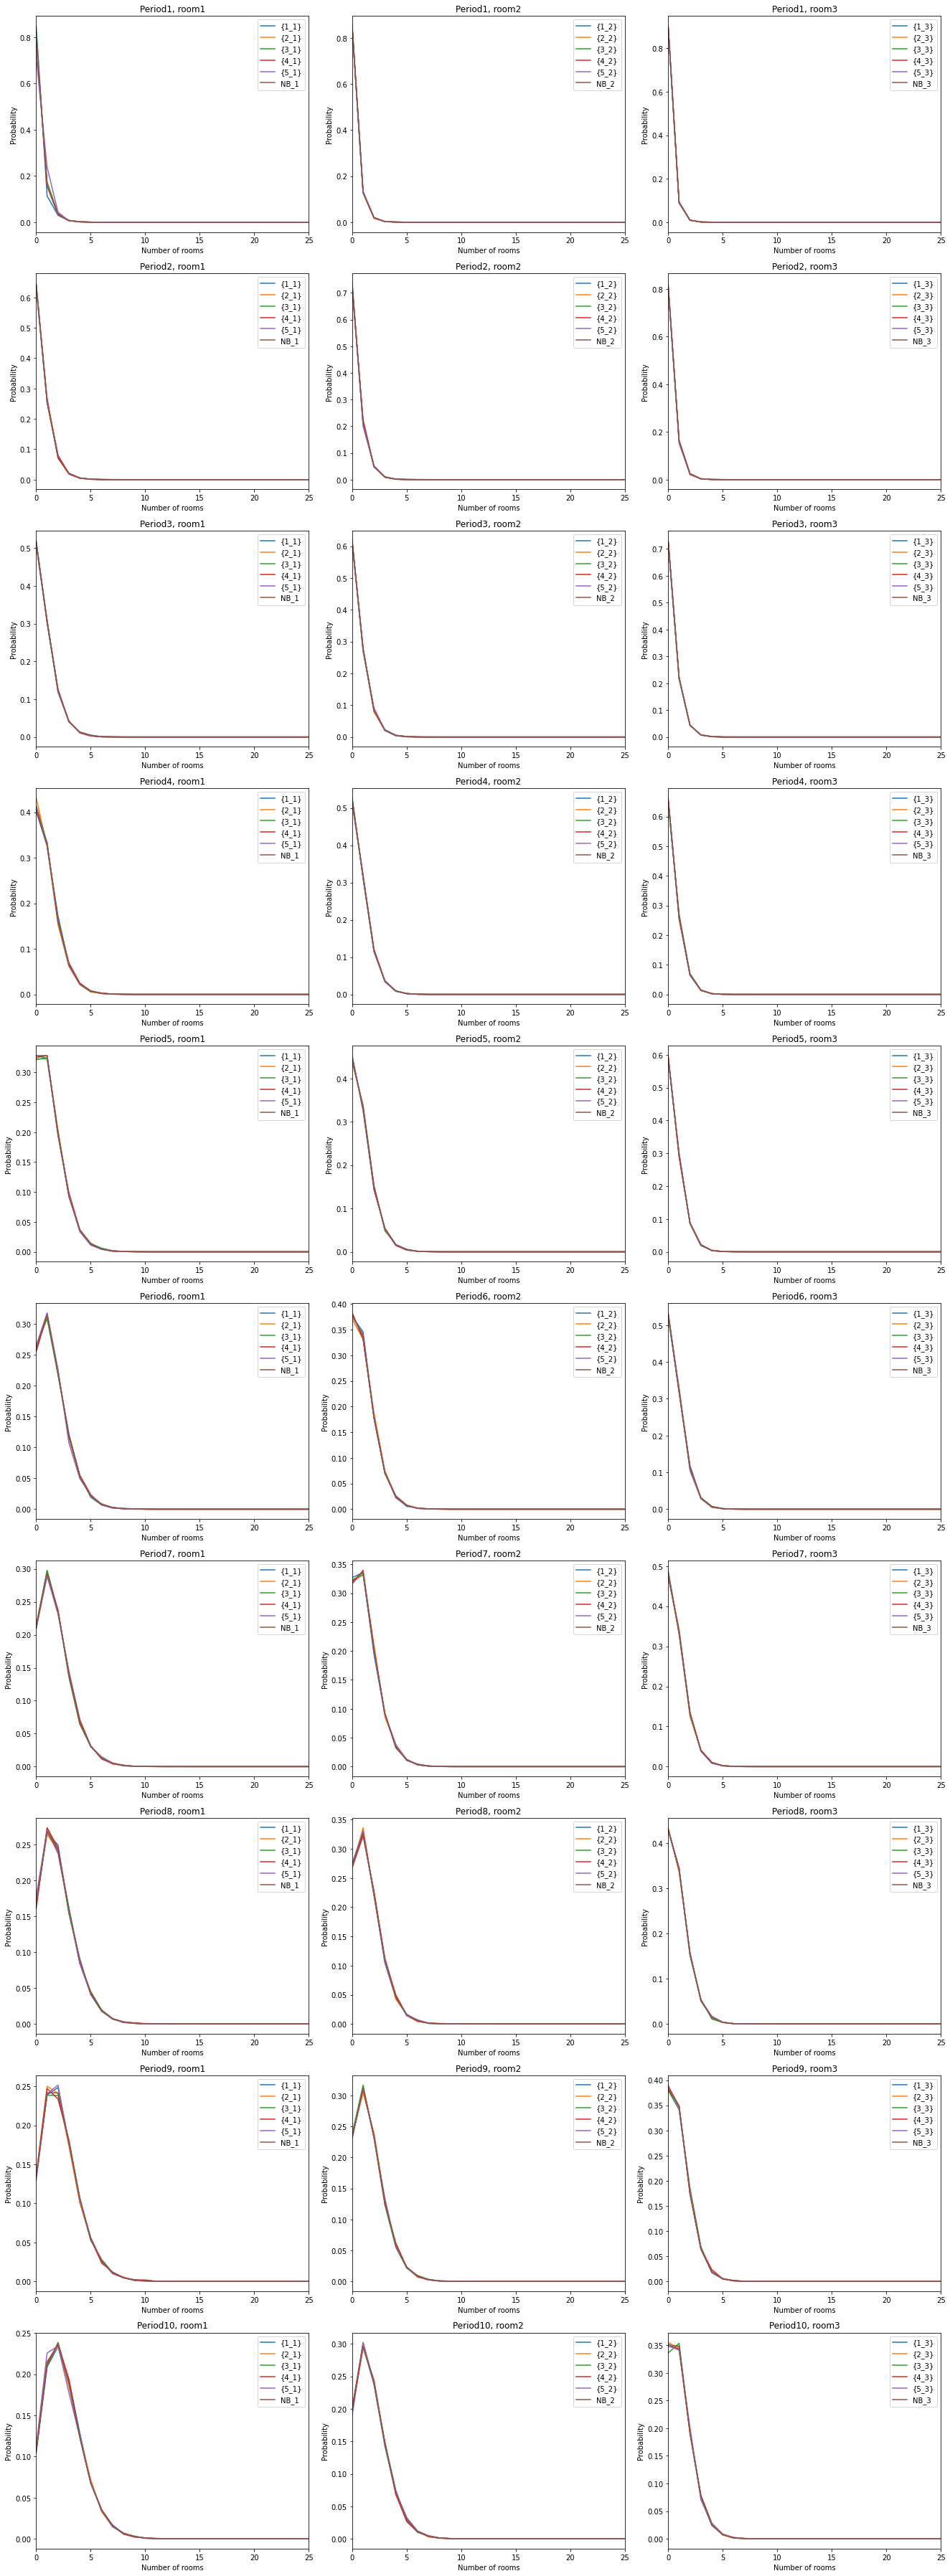

In [86]:
fig, axs = plt.subplots(len(periods), len(rooms))
fig.set_size_inches(18.5, 50)
for t in periods:
    for i in rooms:
        keys = [k for k in df.columns if k[-1]==str(i) or k[-2]==str(i)]
        axs[t-1, i-1].set_title("Period{}, room{}".format(t, i))
        axs[t-i, i-1].set_xlabel("Number of rooms")
        axs[t-i, i-1].set_ylabel("Probability")
        dfs[t][keys].plot(ax=axs[t-1, i-1])
fig.tight_layout()
plt.savefig("S5I3C25m20N10000.jpg")

In [16]:
# functions
def get_dfs(strategies):
    dfs = {}
    for s in scenarios:
        scenario = scenarios[s]
        folder = folder_prefix + scenario + "/"
        dfs[s] = {}
        for mode in strategies:
            path = folder + mode + "_Near0N1000.csv"
            dfs[s][mode] = pd.read_csv(path)
    smarts = {}
    for s in scenarios:
        smarts[s] = concat(dfs[s], strategies, first=strategies[0])
    return smarts

def get_df_rev(dfs):
    target = "R_"
    df_list = []
    for s in scenarios:
        df_temp = get_target(target, dfs[s]).mean()
        df_list.append(df_temp)
        # print(df_temp)

    df_R = pd.concat(df_list, axis=1)
    df_R.columns = scenarios
    return df_R

def print_rev(df, path):
    fig, axs = plt.subplots(2, 3)
    fig.set_size_inches(18.5, 10)
    # print_settings = [["b50", "normal", "b90"], ["m5", "normal", "m20"]]
    print_settings = [["r1", "normal", "r3"], ["d10", "normal", "d40"]]
    for ps in range(len(print_settings)):
        for p in range(len(print_settings[ps])):
            setting = print_settings[ps][p]
            axs[ps, p].set_title("revenue of {}".format(setting))
            axs[ps, p].set_xlabel("beta")
            axs[ps, p].set_ylabel("revenue")
            df[setting].index = [c.split("_")[-1] for c in df.index]
            df[setting].plot(ax=axs[ps, p])
    fig.tight_layout()
    plt.savefig(path)

def show_compare_gamma(target, df, strategies):
    show = show_avg_result(target ,df)
    to_color = lambda x: ("#00" + hex(int((x) * ((pow(16, 4) - 1)/len(strategies)))).split('x')[-1])
    colors = {s:to_color(int(s.split("_g")[-1])+1) for s in strategies}
    show.plot(figsize=(18, 10.5), color=[colors.get(x) for x in show.columns])

def show_actions(df, strategies, path):
    fig, axs = plt.subplots(3, 2)
    fig.set_size_inches(18.5, 15)
    targets = [["AC", "DC"], ["RO", "RI"], ["RA", "RR"]]
    titles = {"AC":"Accpetable", "DC":"Decision",
              "RO":"Revenue from orders", "RI":"Revenue from individuals",
              "RA":"Expected revenue togo if we accept the order",
              "RR":"Expected revenue togo if we reject the order"}
    to_color = lambda x: ("#00" + hex(int((x) * ((pow(16, 4) - 1)/len(strategies)))).split('x')[-1])
    
    for ps in range(len(targets)):
        for p in range(len(targets[ps])):
            target = targets[ps][p]
            axs[ps, p].set_title("{}".format(titles[target]))
            axs[ps, p].set_xlabel("Period")
            axs[ps, p].set_ylabel("value")
            print(target)
            show = show_avg_result(target ,df)
            colors = {s:to_color(int(s.split("_b")[-1])/2+1) for s in strategies}
            show.plot(ax=axs[ps, p], color=[colors.get(x) for x in show.columns])
            # axs[ps, p].plot(show, color=[colors.get(x) for x in show.columns])
    fig.tight_layout()
    plt.savefig(path)

def concat(dfs, strategies, first="MD_naive"):
    # Rename
    periods = list(range(10, 0, -1))
    general = ["Experiment"] + ["order_t" + str(i) for i in periods]
    items = {"decision_t":"DC", "rev_acc_t":"RA", "rev_rej_t":"RR", "rev_order_t":"RO", "rev_ind_t":"RI", "acceptable_t":"AC"}
    revs = {"revenue":"R", "first_k_avg_rev":"AR", "sold_out":"S", "time":"T"}
    concat_list = [dfs[first][general]]
    for s in strategies:
        rename_dic = {r:revs[r]+"_"+s for r in revs}
        rename_dic.update({i+str(t):items[i]+str(t)+"_"+s for i in items for t in periods})
        dfs[s] = dfs[s].rename(columns=rename_dic)
        concat_list.append(dfs[s][list(rename_dic.values())])

    # Concat
    df = pd.concat(concat_list, axis=1)
    return df

def show_avg_result(target, df):
    data = {s:[] for s in strategies}
    periods = [i for i in range(10, 0, -1)]
    for t in periods:
        for s in data:
            key = target + str(t) + "_" + s
            data[s].append(df[key].mean())
    df_item = pd.DataFrame(data, index=periods)
    return df_item

def get_target(target, df):
    rev_keys = [target + s for s in strategies]
    return df[rev_keys]

def add_gap(baseline, df, target):
    for strategy in df.columns:
        df[strategy + "_gap"] = (df[strategy] - df[baseline]).divide(df[baseline])
        df[strategy + "_gap(%)"] = pd.Series(["{0:.2f}%".format(val * 100) for val in df[strategy + "_gap"]], index=df.index)
    return df

def search_key(key, df):
    return df[[k for k in df.columns if key in k]]

def get_item_df(target, df):
    item_dict = {}
    for m in strategies:
        item_dict[m] = []
        for s in scenarios:
            item_dict[m].append(search_key(target ,search_key(m, df[s])).sum(axis=1).mean())
    return pd.DataFrame(item_dict, index=scenarios.keys())

def print_item_compare(target, df):
    fig, axs = plt.subplots(2, 3)
    fig.set_size_inches(18.5, 10)
    print_settings = [["b50", "normal", "b90"], ["m5", "normal", "m20"]]
    colors = {"MD_naive":"#FF0000", "MS_naive":"#880000",
              "MD_smart":"#00FF00", "MS_smart":"#008800",
              "MD_reserved":"#0000FF", "MS_reserved":"#000088"}
    for ps in range(len(print_settings)):
        for p in range(len(print_settings[ps])):
            setting = print_settings[ps][p]
            axs[ps, p].set_title("{} of {}".format(target, setting))
            axs[ps, p].set_xlabel("Period")
            axs[ps, p].set_ylabel("Prob of accepting orders")
            df_show = show_avg_result(target,df[setting])
            df_show.plot(ax=axs[ps, p], color=[colors.get(x) for x in df_show.columns])
    fig.tight_layout()

def get_item_by_keyword(df, keywords, except_key = "NONE"):
    df_key = df
    for key in keywords:
        keys = [k for k in df_key.columns if key in k and except_key not in k]
        df_key = df_key[keys]
    return df_key

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
scenarios = {"normal":"S5I3C25m10b70r2d25K10T10",
             "m5":"S5I3C25m5b70r2d25K10T10",
             "m15":"S5I3C25m15b70r2d25K10T10",  
             "m20":"S5I3C25m20b70r2d25K10T10",
             "b50":"S5I3C25m10b50r2d25K10T10",
             "b90":"S5I3C25m10b90r2d25K10T10",
             "r1":"S5I3C25m10b70r1d25K10T10", 
             "r3":"S5I3C25m10b70r3d25K10T10",
             "d10":"S5I3C25m10b70r2d10K10T10", 
             "d40":"S5I3C25m10b70r2d40K10T10"}
folder_prefix = "BS/"

In [3]:
# Read files
models = ["MD", "MS"]
strategies = ["MD_naive", "MS_naive"] + [m+"_bs_b"+str(b*2) for m in models for b in range(10, -1, -1)]
strategies
dfs = {}
for s in scenarios:
    scenario = scenarios[s]
    folder = "BS/" + scenario + "/"
    dfs[s] = {}
    for mode in strategies:
        path = folder + mode + "_Near0N1000.csv"
        dfs[s][mode] = pd.read_csv(path)

In [4]:
# concat all files
dfs_concat = {}
for s in scenarios:
    dfs_concat[s] = concat(dfs[s], strategies)


In [21]:
get_item_by_keyword(dfs_concat["normal"], ["DC10"])

DC10_MD_naive  DC10_MS_naive  DC10_MD_bs_b20  DC10_MD_bs_b18  \
0                1              1               1               1   
1                1              1               1               1   
2                1              1               1               1   
3                1              1               1               1   
4                0              0               0               0   
..             ...            ...             ...             ...   
995              1              1               1               1   
996              0              0               0               0   
997              1              1               1               1   
998              0              0               0               0   
999              0              0               0               0   

     DC10_MD_bs_b16  DC10_MD_bs_b14  DC10_MD_bs_b12  DC10_MD_bs_b10  \
0                 1               1               1               1   
1                 1               1               1               1   
2                 1               1               1               1   
3                 1               1               1               1   
4                 0               0               0               0   
..              ...             ...             ...             ...   
995               1               1               1               1   
996               0               0               0               0   
997               1               1               1               1   
998               0               0               0               0   
999               0               0               0               0   

     DC10_MD_bs_b8  DC10_MD_bs_b6  ...  DC10_MS_bs_b18  DC10_MS_bs_b16  \
0                1              1  ...               1               1   
1                1              1  ...               1               1   
2                1              1  ...               1               1   
3                1              1  ...               1               1   
4                0              0  ...               0               0   
..             ...            ...  ...             ...             ...   
995              1              1  ...               1               1   
996              0              0  ...               0               0   
997              1              1  ...               1               1   
998              0              0  ...               0               0   
999              0              0  ...               0               0   

     DC10_MS_bs_b14  DC10_MS_bs_b12  DC10_MS_bs_b10  DC10_MS_bs_b8  \
0                 1               1               1              1   
1                 1               1               1              1   
2                 1               1               1              1   
3                 1               1               1              1   
4                 0               0               0              0   
..              ...             ...             ...            ...   
995               1               1               1              1   
996               0               0               0              0   
997               1               1               1              1   
998               0               0               0              0   
999               0               0               0              0   

     DC10_MS_bs_b6  DC10_MS_bs_b4  DC10_MS_bs_b2  DC10_MS_bs_b0  
0                1              1              1              1  
1                1              1              1              1  
2                1              1              1              1  
3                1              1              1              1  
4                0              0              0              0  
..             ...            ...            ...            ...  
995              1              1              1              1  
996              0              0              0              0  

In [22]:
# Find revenue
target = "R_"
df_list = []
for s in scenarios:
    df_temp = get_target(target, dfs_concat[s]).mean()
    df_list.append(df_temp)
    # print(df_temp)

df_R = pd.concat(df_list, axis=1)
df_R.columns = scenarios
df_R.T

R_MD_naive  R_MS_naive  R_MD_bs_b20  R_MD_bs_b18  R_MD_bs_b16  \
normal  500430.883  500577.923   500045.046   500129.110   500085.954   
m5      644806.849  644932.822   644713.534   644703.439   644740.132   
m15     359116.131  361649.359   359116.131   359116.131   359116.131   
m20     309963.905  308485.568   309963.905   309963.905   309963.905   
b50     441423.351  443577.779   440952.419   441406.227   441769.165   
b90     561247.973  562780.135   561335.556   561375.074   561375.074   
r1      512388.425  513566.132   511403.499   511681.729   511801.712   
r3      490282.869  491214.621   491192.865   491093.774   490758.236   
d10     500353.338  500630.358   500233.909   500303.271   500339.283   
d40     487166.797  484823.334   486942.958   486956.171   487163.524   

        R_MD_bs_b14  R_MD_bs_b12  R_MD_bs_b10  R_MD_bs_b8  R_MD_bs_b6  ...  \
normal   500128.596   500231.526   500265.356  500261.953  500351.697  ...   
m5       644762.270   644762.270   644774.614  644774.614  644776.246  ...   
m15      359116.131   359116.131   359116.131  359116.131  359116.131  ...   
m20      309963.905   309963.905   309963.905  309963.905  309963.905  ...   
b50      442003.791   442225.813   442113.628  442020.792  441848.355  ...   
b90      561366.950   561373.521   561247.307  561247.307  561248.614  ...   
r1       511919.619   512050.264   512102.426  512160.568  512238.894  ...   
r3       490663.807   490440.050   490333.131  490393.219  490316.524  ...   
d10      500350.187   500355.858   500368.887  500349.805  500335.682  ...   
d40      487148.661   487171.565   487152.816  487201.755  487274.545  ...   

        R_MS_bs_b18  R_MS_bs_b16  R_MS_bs_b14  R_MS_bs_b12  R_MS_bs_b10  \
normal   501178.165   501111.819   501092.624   501422.394   501065.287   
m5       644838.987   644833.867   644890.573   644940.071   644934.602   
m15      361480.455   361636.093   362183.999   361699.982   361306.065   
m20      308039.013   308301.227   307713.543   308094.512   308018.976   
b50      443782.014   444327.150   444549.758   444716.694   444322.221   
b90      562274.653   562350.059   561995.739   562603.744   562304.137   
r1       513458.750   513014.662   513607.022   513259.560   513343.204   
r3       491189.350   491475.800   491473.927   491720.985   491332.262   
d10      500524.625   500594.717   500564.638   500580.927   500640.325   
d40      486027.925   485489.084   486558.045   485235.734   486802.902   

        R_MS_bs_b8  R_MS_bs_b6  R_MS_bs_b4  R_MS_bs_b2  R_MS_bs_b0  
normal  501097.836  501021.424  500989.557  500883.860  501022.739  
m5      644953.515  644904.375  644902.728  644921.344  644885.872  
m15     362006.705  361726.484  361634.237  361635.108  361478.315  
m20     308348.348  307739.054  308533.490  307662.161  308314.981  
b50     444639.910  444523.505  443918.063  443645.229  443575.965  
b90     562361.807  562478.473  561995.583  562704.373  562176.448  
r1      513567.728  513773.638  513719.886  514096.671  513798.872  
r3      491418.026  491525.929  491470.635  491130.660  491715.754  
d10     500586.135  500700.193  500708.264  500677.258  500661.451  
d40     485960.399  486034.456  485573.217  485976.856  485912.951  

[10 rows x 24 columns]

In [93]:
# Find optimal TD, TS
temp = get_item_by_keyword(df_R.T, ["MD_bs"])
optTD = temp.idxmax(axis=1).to_dict()
temp = get_item_by_keyword(df_R.T, ["MS_bs"])
optTS = temp.idxmax(axis=1).to_dict()
print(optTD)
print(optTS)

{'normal': 'R_MD_bs_b0', 'm5': 'R_MD_bs_b0', 'm15': 'R_MD_bs_b20', 'm20': 'R_MD_bs_b20', 'b50': 'R_MD_bs_b12', 'b90': 'R_MD_bs_b18', 'r1': 'R_MD_bs_b0', 'r3': 'R_MD_bs_b20', 'd10': 'R_MD_bs_b10', 'd40': 'R_MD_bs_b6'}
{'normal': 'R_MS_bs_b12', 'm5': 'R_MS_bs_b8', 'm15': 'R_MS_bs_b14', 'm20': 'R_MS_bs_b4', 'b50': 'R_MS_bs_b12', 'b90': 'R_MS_bs_b2', 'r1': 'R_MS_bs_b2', 'r3': 'R_MS_bs_b20', 'd10': 'R_MS_bs_b4', 'd40': 'R_MS_bs_b10'}


In [128]:
# Show the decisions of 4 policies
def print_decision(targets, titles, path = ""):
    inch = 6
    fig, axs = plt.subplots(len(targets), 2)
    fig.set_size_inches(inch*2, 5*len(targets))
    
    for ps in range(len(targets)):
        for p in range(len(targets[ps])):
            fig_index = (ps, p)
            if len(targets) == 1:
                fig_index = p
                
            target = targets[ps][p]
            axs[fig_index].set_title("{}".format(titles[target]), fontsize='16')
            axs[fig_index].set_xlabel("Period", fontsize='14')
            axs[fig_index].set_ylabel("Acceptance rate", fontsize='14')
            axs[fig_index].tick_params(axis='both', which='major', labelsize=12)
            key_list = ["MD_naive", "MS_naive", optTD[target][2:], optTS[target][2:]]
            key_rename = {"MD_naive":"ND", "MS_naive":"NS", optTD[target][2:]:"TD", optTS[target][2:]:"TS"}
            show = show_avg_result("DC" ,dfs_concat[target])[key_list]
            show = show.rename(columns =  key_rename)
            show.plot(ax=axs[fig_index], style=['-', '--*', '-.o', ':x'])
    #         axs[ps, p].plot(show, color=[colors.get(x) for x in show.columns])
    fig.tight_layout()
    if path != "":
        plt.savefig(path)

{'m5': 'high individual demand (low m)', 'normal': 'normal', 'm15': 'moderate individual demand (moderate m)', 'm20': 'low individual demand (high m)', 'b50': 'low order price (low $\\beta$)', 'b90': 'high order price (high $\\beta$)', 'r1': 'low no-order rate (low $\\theta$)', 'r3': 'high no-order rate (high $\\theta$)', 'd10': 'low order demand (low $\\gamma$)', 'd40': 'high order demand (high $\\gamma$)'}


/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs10030746/

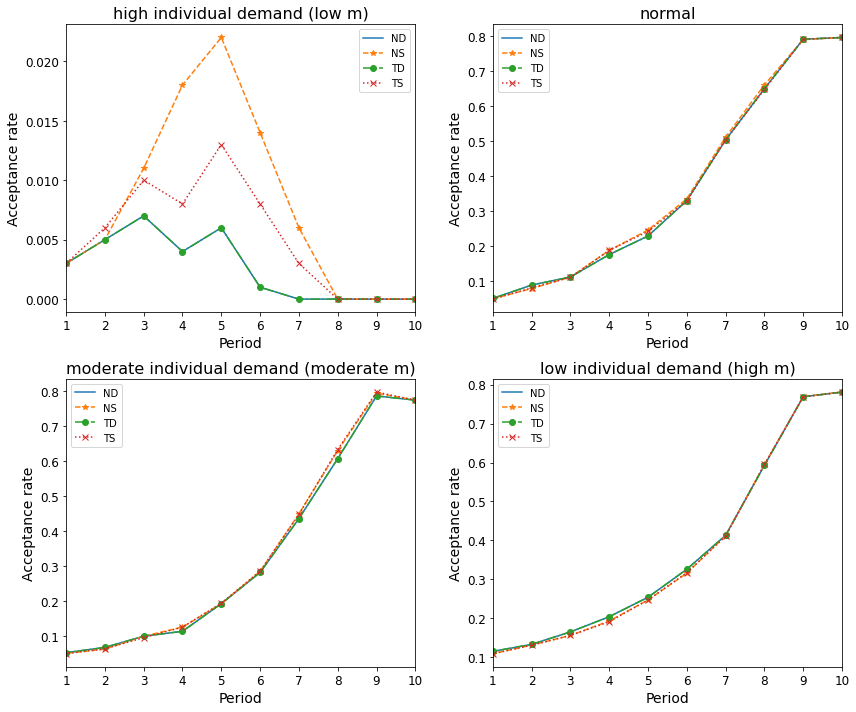

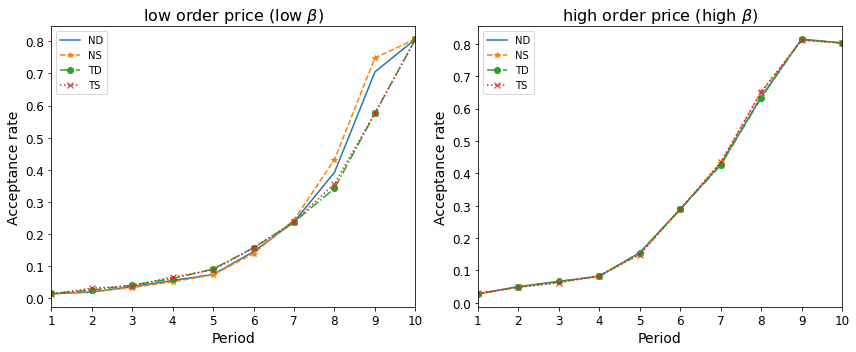

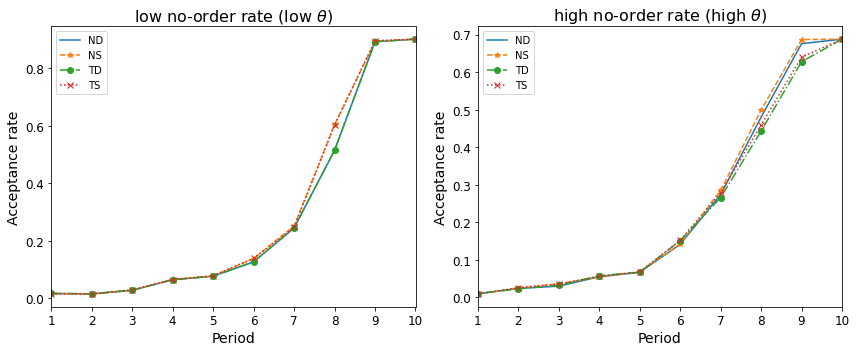

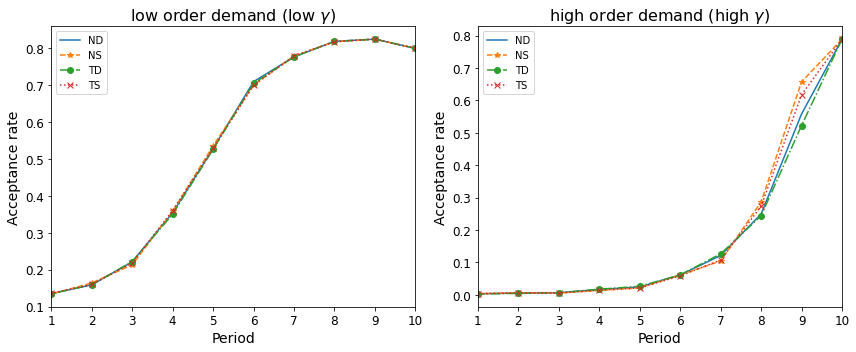

In [131]:
# targets = [["m5", "normal"], ["m15", "m20"], ["b50", "b90"], ["r1", "r3"], ["d10", "d40"]]
titles = {"m5":r"high individual demand (low m)", "normal":"normal",
          "m15":r"moderate individual demand (moderate m)", "m20":r"low individual demand (high m)",
          "b50":r"low order price (low $\beta$)", "b90":r"high order price (high $\beta$)",
          "r1":r"low no-order rate (low $\theta$)", "r3":r"high no-order rate (high $\theta$)",
          "d10":r"low order demand (low $\gamma$)", "d40":r"high order demand (high $\gamma$)"}
print(titles)
targets_list = [[["m5", "normal"], ["m15", "m20"]], [["b50", "b90"]], [["r1", "r3"]], [["d10", "d40"]]]
folder = "../../myThesis/images/"
paths = ["m", "beta", "theta", "gamma"]
for t in range(len(targets_list)):
    targets = targets_list[t]
    path = paths[t]
    print_decision(targets, titles, folder + path)

In [201]:
# Find best smart
TD = get_item_by_keyword(df_R.T, ["MD_bs"]).max(axis=1)
TD = pd.DataFrame(TD, columns = ["TD"])
TS = get_item_by_keyword(df_R.T, ["MS_bs"]).max(axis=1)
TS = pd.DataFrame(TS, columns = ["TS"])
df_compare = pd.concat([df_R.T[["R_MD_naive", "R_MS_naive"]], TD, TS], axis=1)
df_compare = df_compare.rename(columns={"R_MD_naive":"ND", "R_MS_naive":"NS"})
df_compare

ND          NS          TD          TS
normal  500430.883  500577.923  500430.883  501422.394
m5      644806.849  644932.822  644806.849  644953.515
m15     359116.131  361649.359  359116.131  362183.999
m20     309963.905  308485.568  309963.905  308533.490
b50     441423.351  443577.779  442225.813  444716.694
b90     561247.973  562780.135  561375.074  562704.373
r1      512388.425  513566.132  512388.425  514096.671
r3      490282.869  491214.621  491192.865  491872.531
d10     500353.338  500630.358  500368.887  500708.264
d40     487166.797  484823.334  487274.545  486802.902

In [185]:
# show results
df_gap = add_gap("ND", df_compare, "")
df_show = get_item_by_keyword(df_gap, ["gap(%)"])
# df_compare = df_gap[[k for k in df_gap.columns if "naive" in k or "b20" in k]]
# rename_dic = {"R_MD_naive_gap(%)":"ND_gap(%)", "R_MS_naive_gap(%)":"NS_gap(%)", 
#               "R_MD_bs_b20_gap(%)":"SD_b20_gap(%)", "R_MS_bs_b20_gap(%)":"SD_b20_gap(%)"}
# df_compare = df_compare.rename(columns=rename_dic)
df_show

ND_gap(%) NS_gap(%) TD_gap(%) TS_gap(%)
normal     0.00%     0.03%     0.00%     0.20%
m5         0.00%     0.02%     0.00%     0.02%
m15        0.00%     0.71%     0.00%     0.85%
m20        0.00%    -0.48%     0.00%    -0.46%
b50        0.00%     0.49%     0.18%     0.75%
b90        0.00%     0.27%     0.02%     0.26%
r1         0.00%     0.23%     0.00%     0.33%
r3         0.00%     0.19%     0.19%     0.32%
d10        0.00%     0.06%     0.00%     0.07%
d40        0.00%    -0.48%     0.02%    -0.07%

In [67]:
# Find revenue
target = "R_"
df_list = []
for s in scenarios:
    df_temp = get_target(target, dfs_concat[s]).mean()
    df_list.append(df_temp)
    # print(df_temp)

df_R = pd.concat(df_list, axis=1)
df_R.columns = scenarios

get_item_by_keyword(df_R.T, ["MS_bs"])[["R_MS_bs_b20","R_MS_bs_b18","R_MS_bs_b16","R_MS_bs_b14","R_MS_bs_b12","R_MS_bs_b10"]]

R_MS_bs_b20  R_MS_bs_b18  R_MS_bs_b16  R_MS_bs_b14  R_MS_bs_b12  \
normal   501076.491   501178.165   501111.819   501092.624   501422.394   
m5       644840.512   644838.987   644833.867   644890.573   644940.071   
m15      362109.611   361480.455   361636.093   362183.999   361699.982   
m20      308414.631   308039.013   308301.227   307713.543   308094.512   
b50      442414.287   443782.014   444327.150   444549.758   444716.694   
b90      562482.725   562274.653   562350.059   561995.739   562603.744   
r1       513335.165   513458.750   513014.662   513607.022   513259.560   
r3       491872.531   491189.350   491475.800   491473.927   491720.985   
d10      500316.000   500524.625   500594.717   500564.638   500580.927   
d40      485236.807   486027.925   485489.084   486558.045   485235.734   

        R_MS_bs_b10  
normal   501065.287  
m5       644934.602  
m15      361306.065  
m20      308018.976  
b50      444322.221  
b90      562304.137  
r1       513343.204  
r3       491332.262  
d10      500640.325  
d40      486802.902

In [207]:
TD = get_item_by_keyword(df_R.T, ["MD_bs"]).max(axis=1)
TD = pd.DataFrame(TD, columns = ["TD"])
TS = get_item_by_keyword(df_R.T, ["MS_bs"]).max(axis=1)
TS = pd.DataFrame(TS, columns = ["TS"])
df_compare = pd.concat([df_R.T[["R_MD_naive", "R_MS_naive"]], TD, TS], axis=1)
df_compare = df_compare.rename(columns={"R_MD_naive":"ND", "R_MS_naive":"NS"})
df_compare.sum()/10000

ND    480718.0521
NS    481223.8031
TD    480914.3377
TS    481799.4833
dtype: float64

In [213]:
df_total_avg = pd.DataFrame(df_compare.sum()/10000, columns=["average_revenue"])
df_total_avg.T
df_gap = add_gap("ND", df_total_avg.T, "")
df_show = get_item_by_keyword(df_gap, ["gap(%)"])
# df_compare = df_gap[[k for k in df_gap.columns if "naive" in k or "b20" in k]]
# rename_dic = {"R_MD_naive_gap(%)":"ND_gap(%)", "R_MS_naive_gap(%)":"NS_gap(%)", 
#               "R_MD_bs_b20_gap(%)":"SD_b20_gap(%)", "R_MS_bs_b20_gap(%)":"SD_b20_gap(%)"}
# df_compare = df_compare.rename(columns=rename_dic)
df_show

ND_gap(%) NS_gap(%) TD_gap(%) TS_gap(%)
average_revenue     0.00%     0.11%     0.04%     0.22%

In [90]:
# Find revenue
target = "T_"
df_list = []
for s in scenarios:
    df_temp = get_target(target, dfs_concat[s]).sum()
    df_list.append(df_temp)
    # print(df_temp)

df_T = pd.concat(df_list, axis=1)
df_T.columns = scenarios
df_T.T
get_item_by_keyword(df_T.T, ["MS"])[["T_MS_bs_b8","T_MS_bs_b6","T_MS_bs_b4","T_MS_bs_b2","T_MS_bs_b0"]].astype('int32')

T_MS_bs_b8  T_MS_bs_b6  T_MS_bs_b4  T_MS_bs_b2  T_MS_bs_b0
normal         433         429         429         430         429
m5             518         545         526         526         530
m15            337         335         335         335         335
m20            354         352         353         352         355
b50            470         467         467         456         449
b90            361         361         361         362         361
r1             468         471         472         481         473
r3             344         346         344         337         344
d10            411         414         413         413         414
d40            407         411         398         407         407

In [236]:
TD = get_item_by_keyword(df_T.T, ["MS_bs"]).sum(axis = 1)
# .sum(axis=1)
TD.mean()
# TD = get_item_by_keyword(df_T.T, ["MD_bs"]).mean(axis=1)
# TD = pd.DataFrame(TD, columns = ["TD"])
# TS = get_item_by_keyword(df_T.T, ["MS_bs"]).mean(axis=1)
# TS = pd.DataFrame(TS, columns = ["TS"])
# df_compare = pd.concat([df_T.T[["T_MD_naive", "T_MS_naive"]], TD, TS], axis=1)
# df_compare = df_compare.rename(columns={"R_MD_naive":"ND", "R_MS_naive":"NS"})
# df_compare.mean(axis=0)

4553.6

In [193]:
TD

TD
normal  0.001727
m5      0.001182
m15     0.001091
m20     0.001455
b50     0.001545
b90     0.001455
r1      0.001636
r3      0.001182
d10     0.001727
d40     0.001455

___

In [93]:
strategies = ["MD_bs_b" + str(b*2) for b in range(10, -1, -1)]
MD_bss = get_dfs(strategies)
MD_bs = get_df_rev(MD_bss)
MD_bs

normal          r1          r3         d10         d40
R_MD_bs_b20  500045.046  511403.499  491192.865  500233.909  486942.958
R_MD_bs_b18  500129.110  511681.729  491093.774  500303.271  486956.171
R_MD_bs_b16  500085.954  511801.712  490758.236  500339.283  487163.524
R_MD_bs_b14  500128.596  511919.619  490663.807  500350.187  487148.661
R_MD_bs_b12  500231.526  512050.264  490440.050  500355.858  487171.565
R_MD_bs_b10  500265.356  512102.426  490333.131  500368.887  487152.816
R_MD_bs_b8   500261.953  512160.568  490393.219  500349.805  487201.755
R_MD_bs_b6   500351.697  512238.894  490316.524  500335.682  487274.545
R_MD_bs_b4   500374.673  512272.969  490327.405  500343.208  487080.021
R_MD_bs_b2   500397.262  512290.649  490291.113  500343.208  487035.828
R_MD_bs_b0   500430.883  512388.425  490282.869  500353.338  487166.797

/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs10030746/

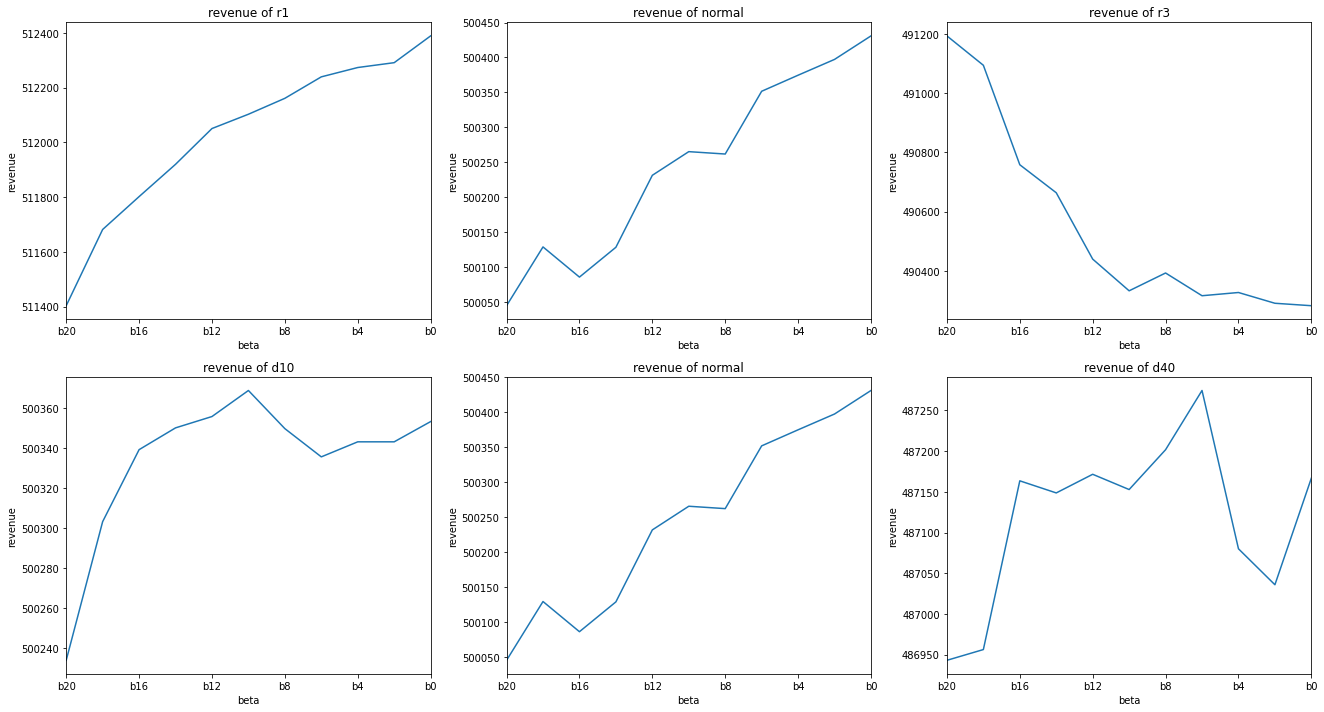

In [42]:
print_rev(MD_bs, "BS/MD_bs_2to0_rd.jpg")

AC
DC
RO
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs

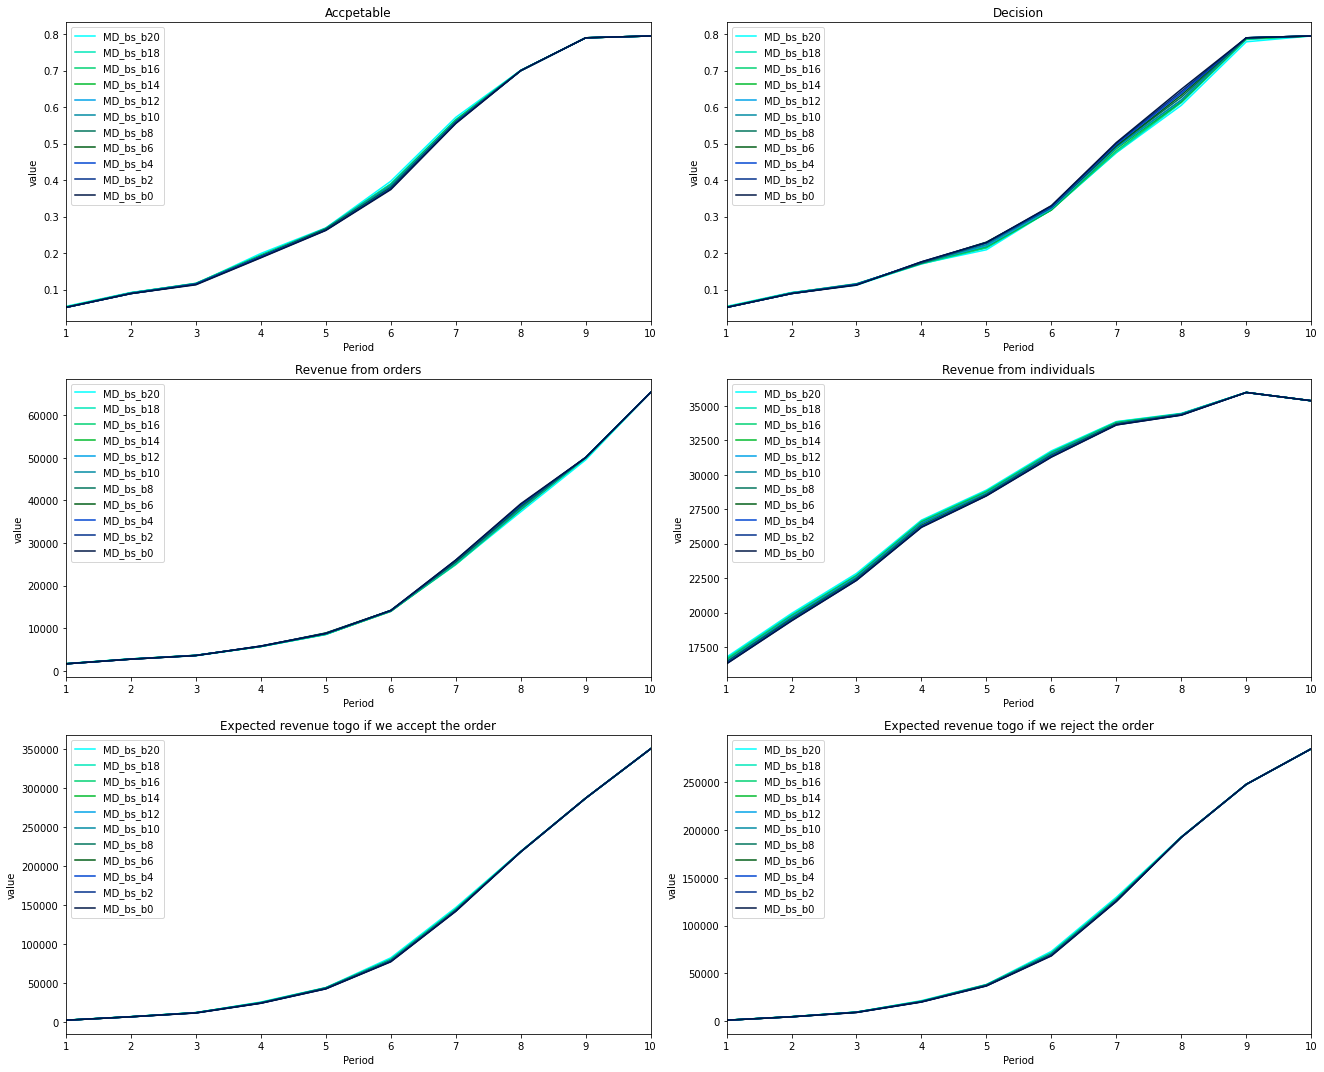

In [43]:
show_actions(MD_bss["normal"], strategies, "BS/MD/normal_2to0_rd.jpg")

AC
DC
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs100

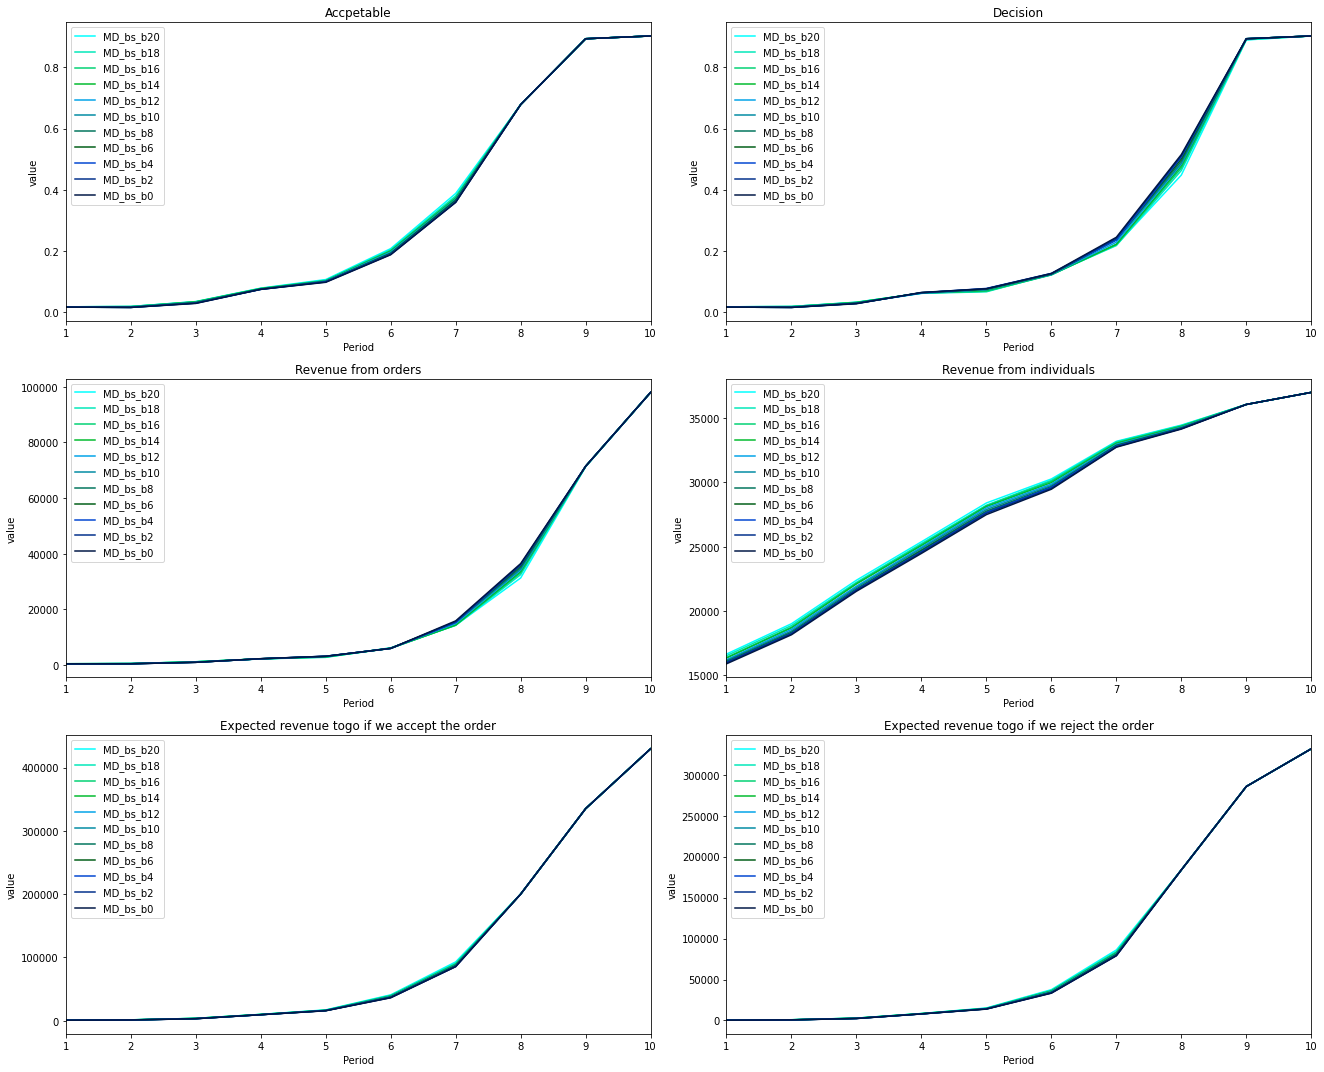

In [44]:
show_actions(MD_bss["r1"], strategies, "BS/MD/r1_2to0.jpg")

AC
DC
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs100

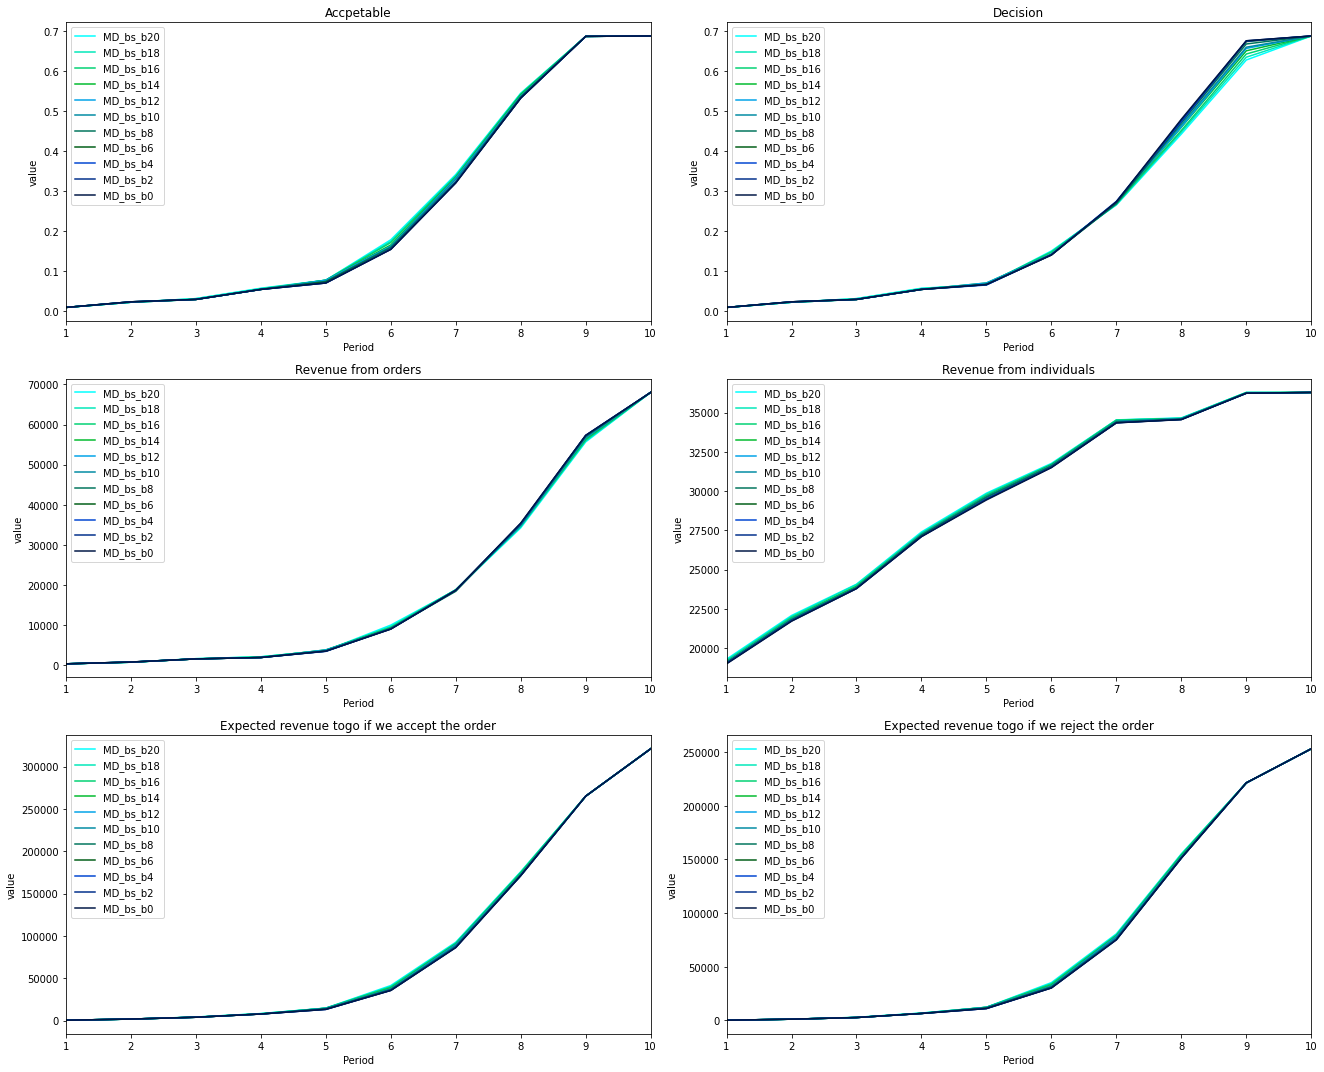

In [45]:
show_actions(MD_bss["r3"], strategies, "BS/MD/r3_2to0.jpg")

AC
DC
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs100

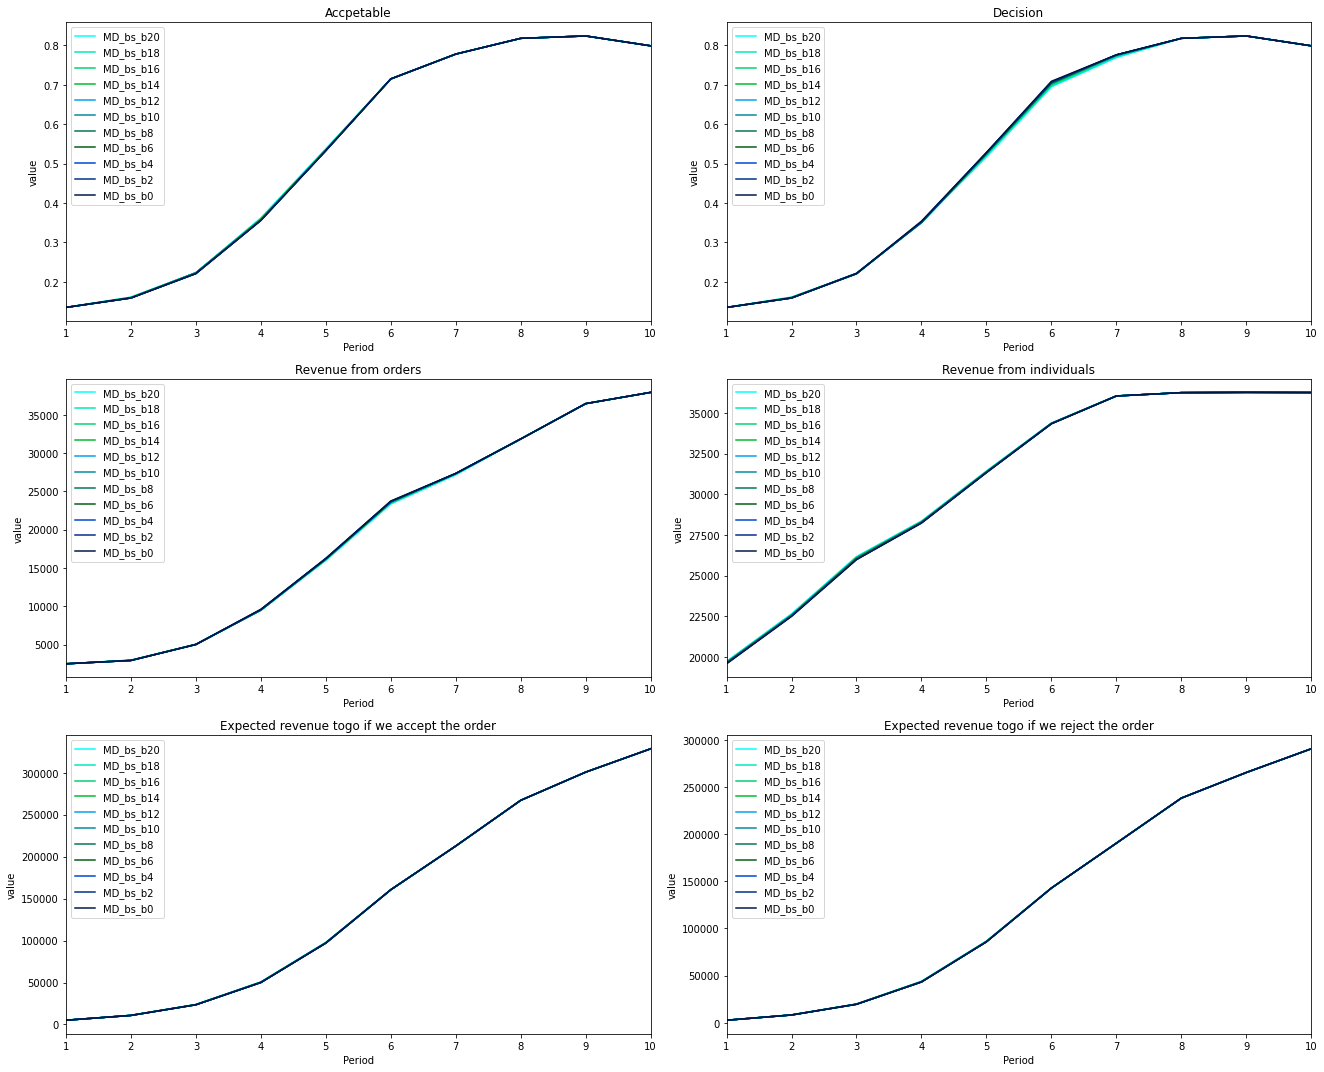

In [46]:
show_actions(MD_bss["d10"], strategies, "BS/MD/d10_2to0.jpg")

AC
DC
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs100

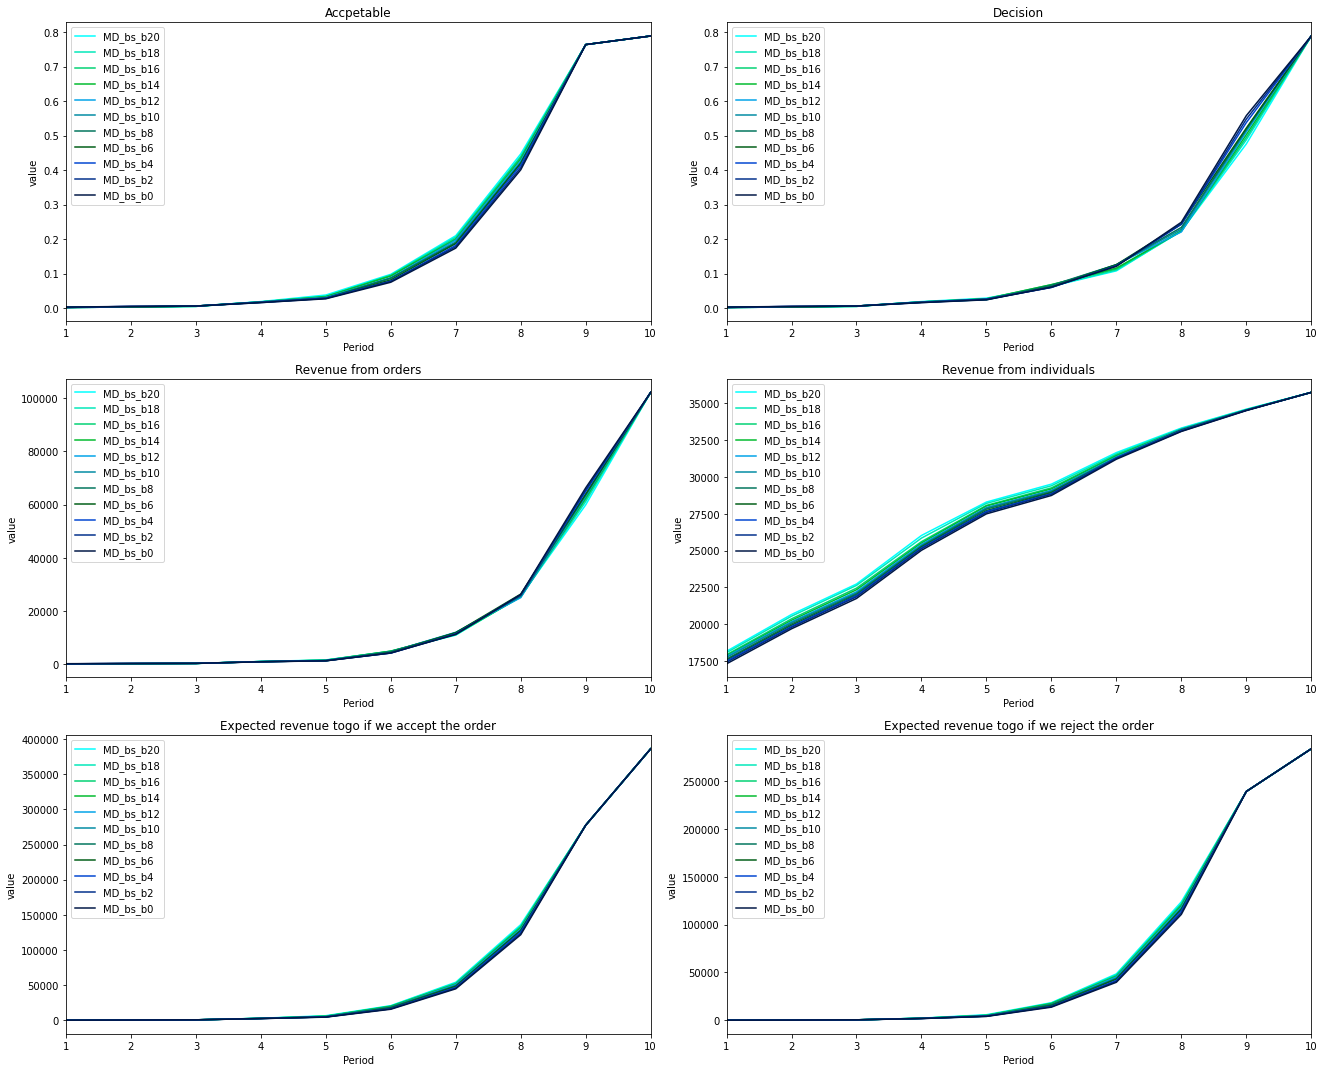

In [47]:
show_actions(MD_bss["d40"], strategies, "BS/MD/d40_2to0.jpg")

In [48]:
strategies = ["MS_bs_b" + str(b*2) for b in range(10, -1, -1)]
MS_bss = get_dfs(strategies)
MS_bs = get_df_rev(MS_bss)
MS_bs

normal          r1          r3         d10         d40
R_MS_bs_b20  501076.491  513335.165  491872.531  500316.000  485236.807
R_MS_bs_b18  501178.165  513458.750  491189.350  500524.625  486027.925
R_MS_bs_b16  501111.819  513014.662  491475.800  500594.717  485489.084
R_MS_bs_b14  501092.624  513607.022  491473.927  500564.638  486558.045
R_MS_bs_b12  501422.394  513259.560  491720.985  500580.927  485235.734
R_MS_bs_b10  501065.287  513343.204  491332.262  500640.325  486802.902
R_MS_bs_b8   501097.836  513567.728  491418.026  500586.135  485960.399
R_MS_bs_b6   501021.424  513773.638  491525.929  500700.193  486034.456
R_MS_bs_b4   500989.557  513719.886  491470.635  500708.264  485573.217
R_MS_bs_b2   500883.860  514096.671  491130.660  500677.258  485976.856
R_MS_bs_b0   501022.739  513798.872  491715.754  500661.451  485912.951

/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs10030746/

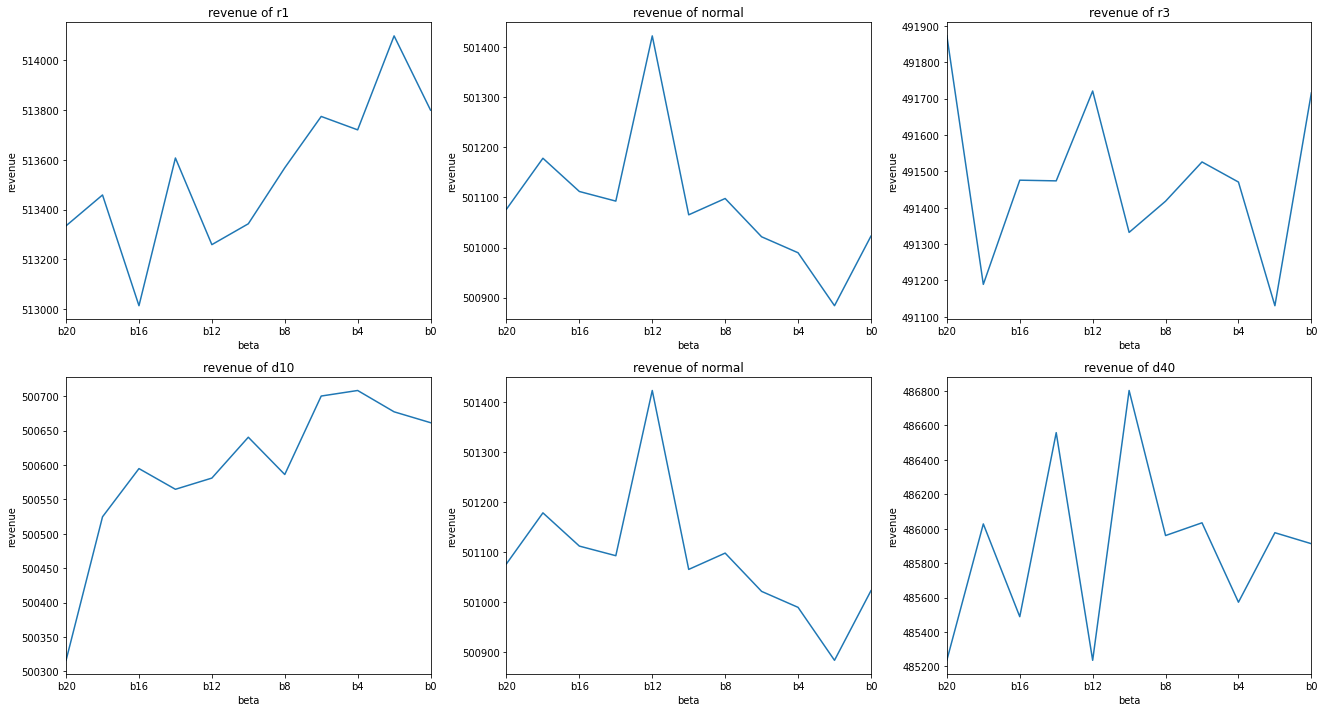

In [49]:
print_rev(MS_bs, "BS/MS_bs_2to0_rd.jpg")

AC
DC
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs100

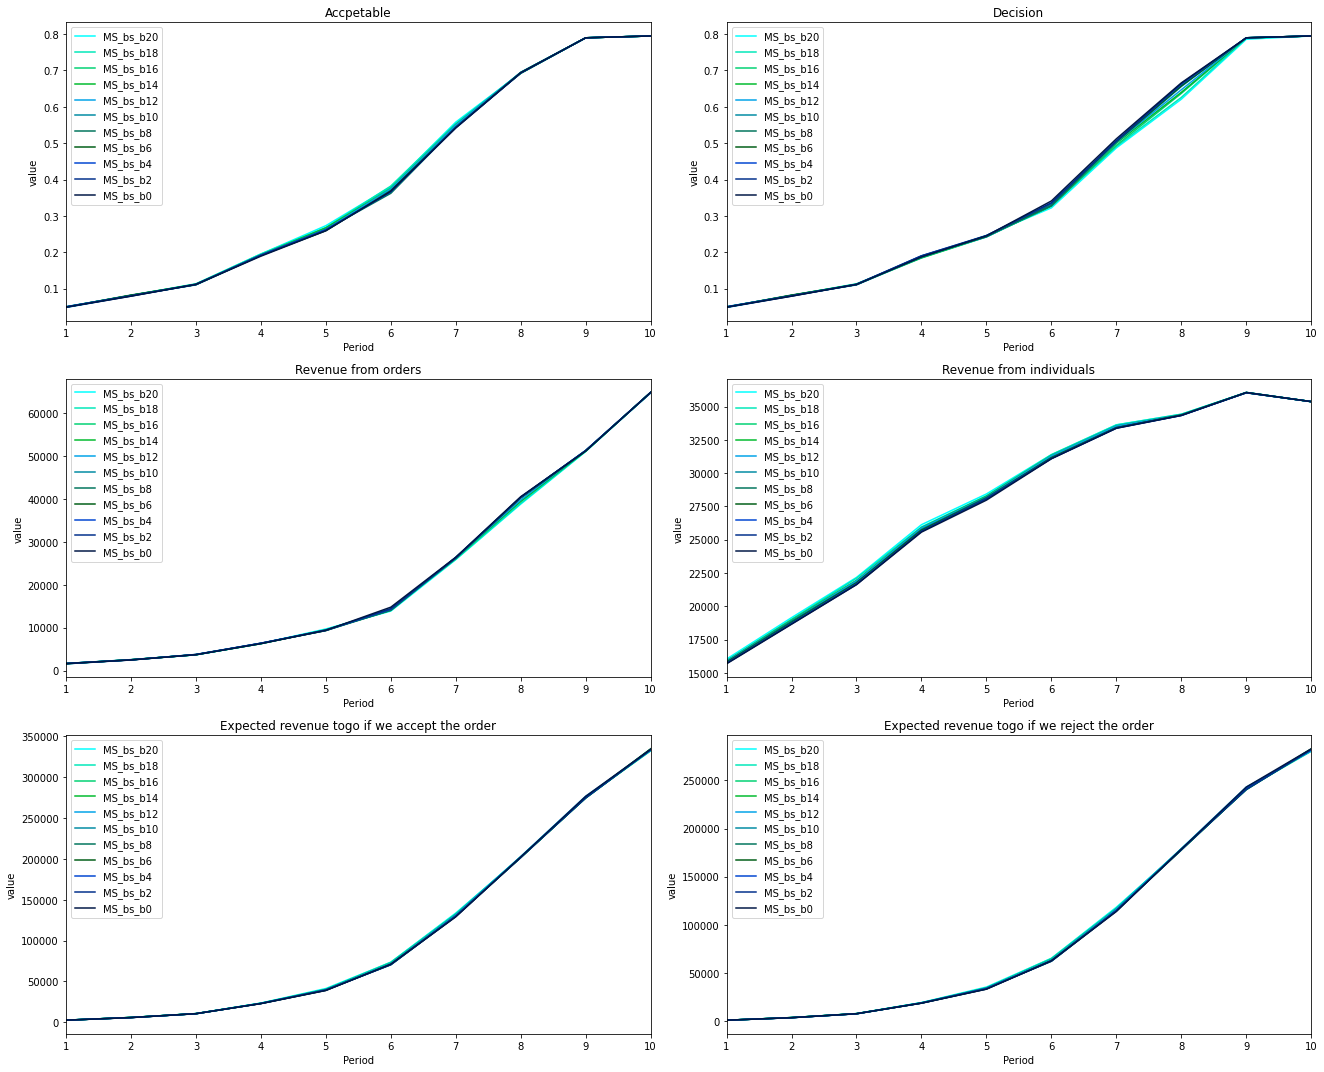

In [19]:
show_actions(MS_bss["normal"], strategies, "BS/MS/normal_2to0.jpg")

AC
DC
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs100

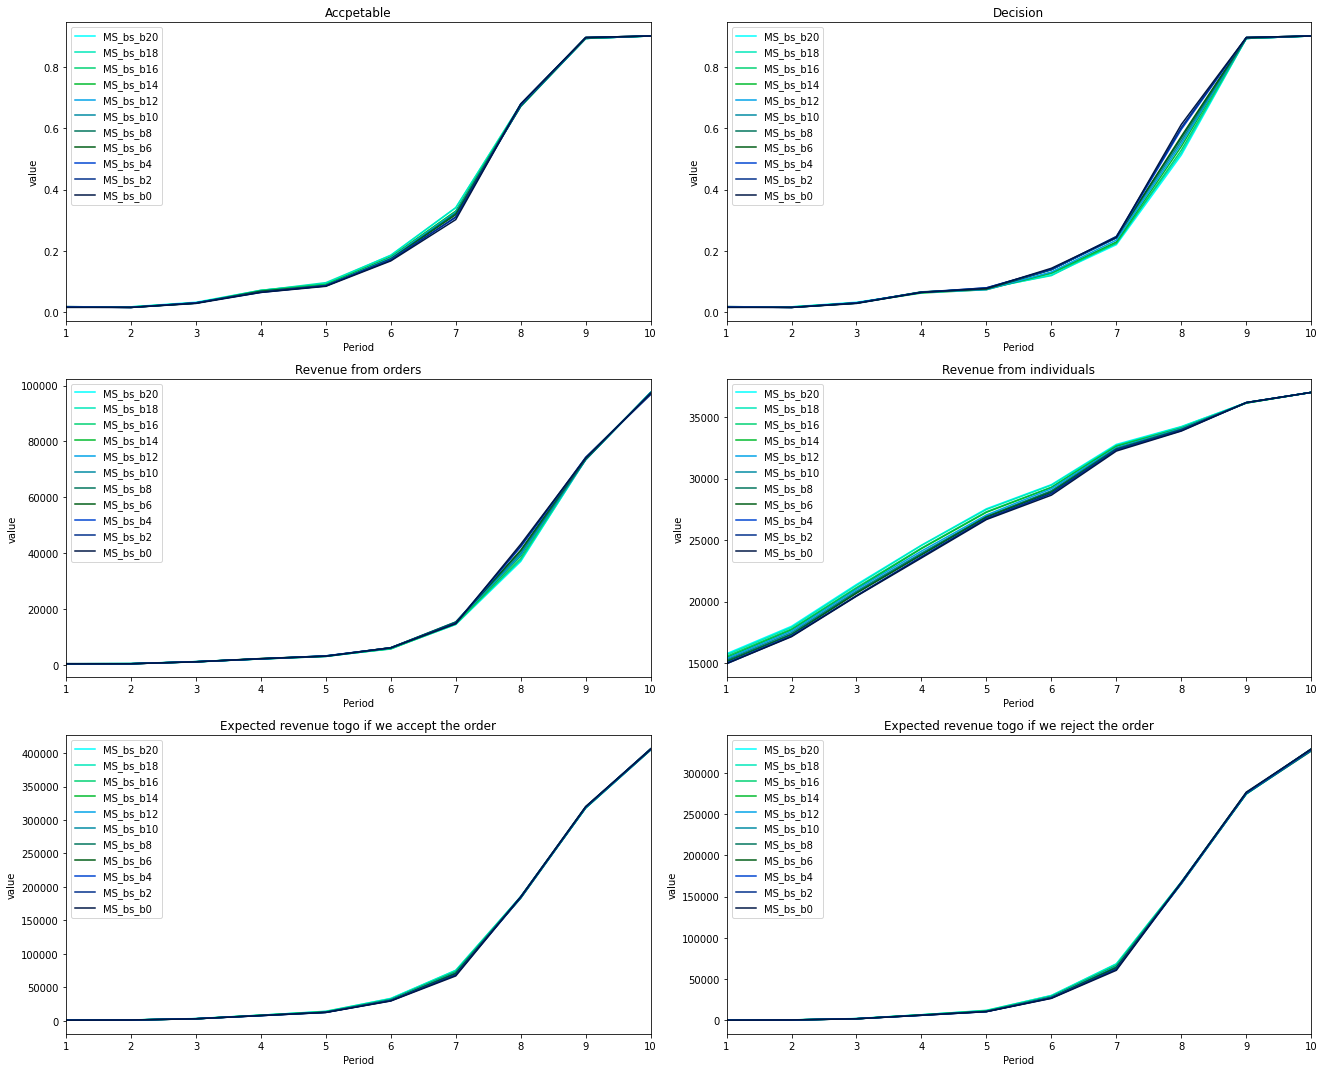

In [50]:
show_actions(MS_bss["r1"], strategies, "BS/MS/r1_2to0.jpg")

AC
DC
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs100

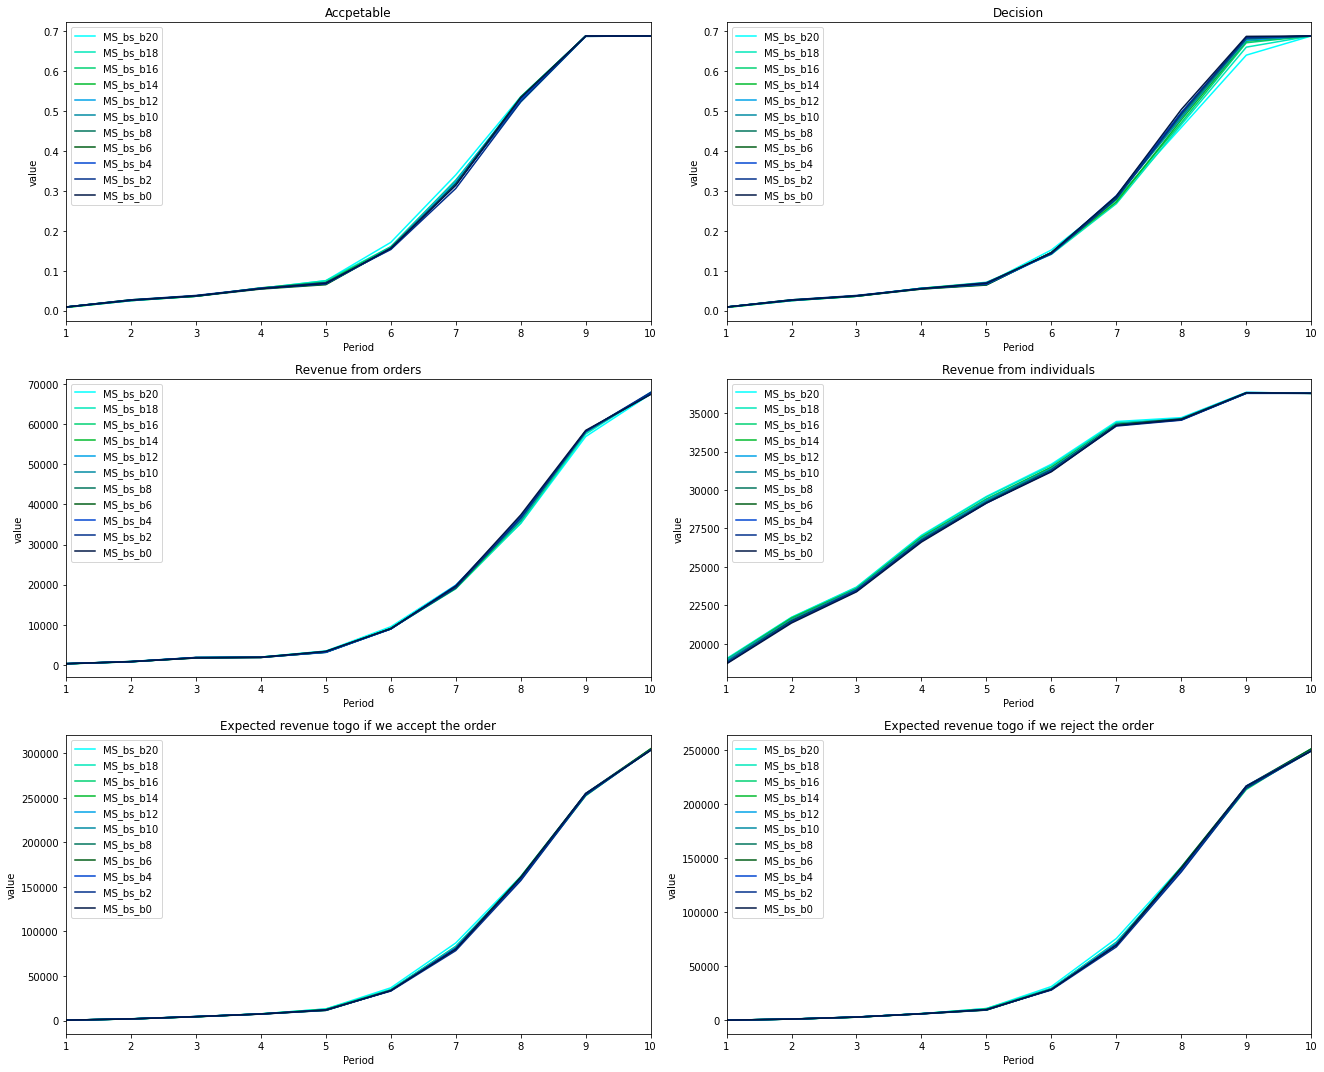

In [51]:
show_actions(MS_bss["r3"], strategies, "BS/MS/r3_2to0.jpg")

AC
DC
RO
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs

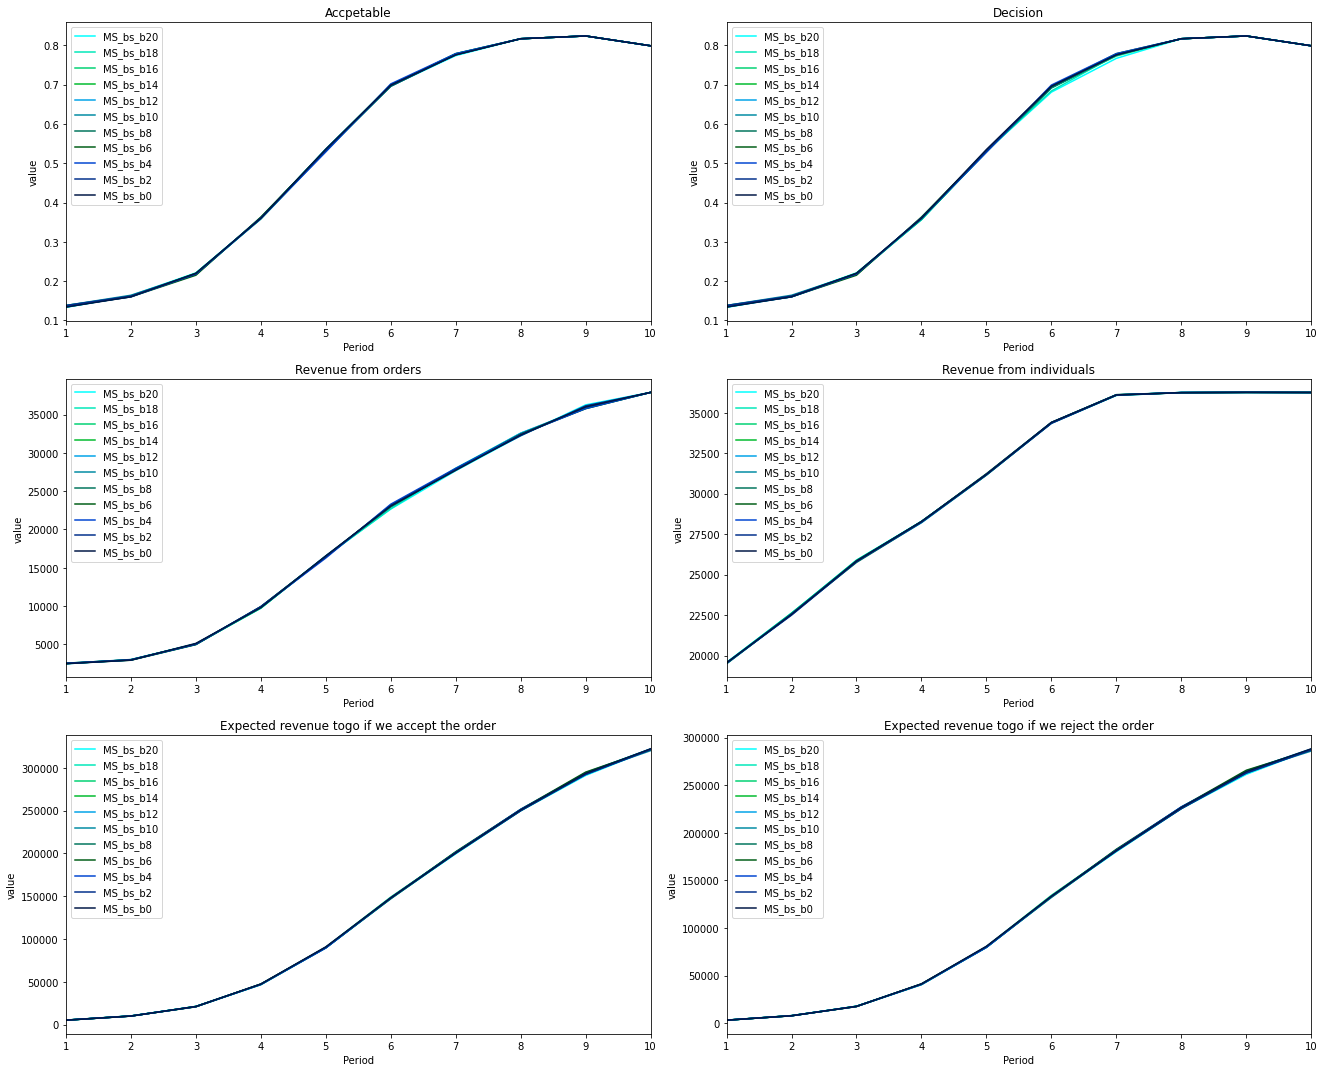

In [52]:
show_actions(MS_bss["d10"], strategies, "BS/MS/d10_2to0.jpg")

AC
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs100307

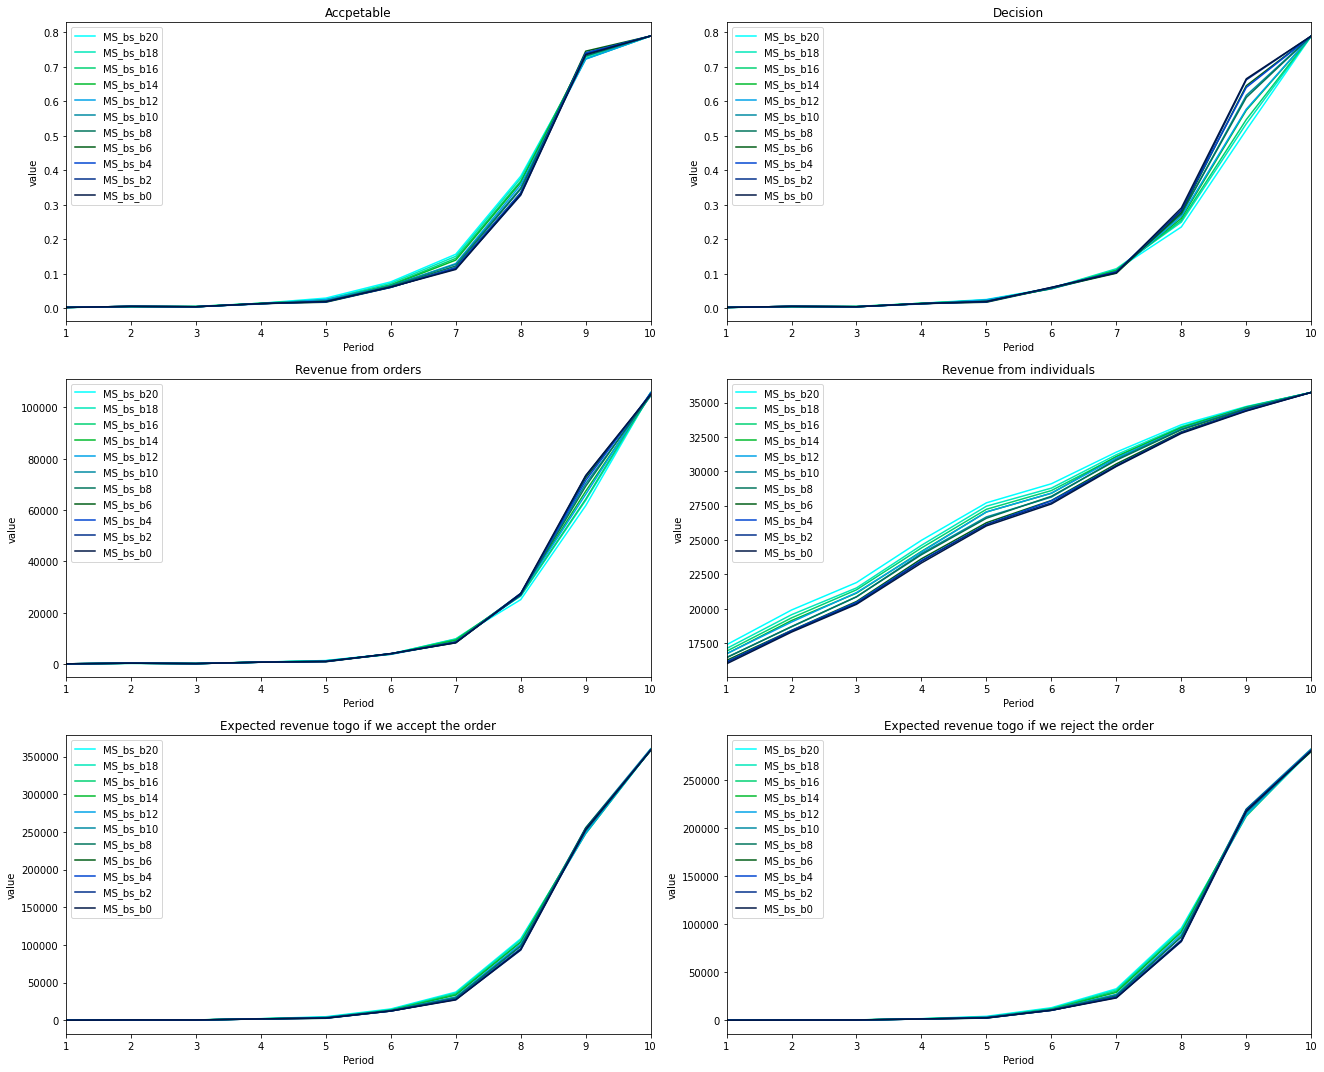

In [53]:
show_actions(MS_bss["d40"], strategies, "BS/MS/d40_2to0.jpg")

In [24]:
total_time = 0
for setting in MD_bss:
    time = MD_bss[setting][[k for k in MD_bss[setting].columns if "T" in k]].sum().sum()
    total_time += time
    print("Setting: {} | time: {}".format(setting, time))
print("\nTotal time: {} | hr: {}".format(total_time, total_time/3600))

Setting: normal | time: 19.0
Setting: b50 | time: 17.0
Setting: b90 | time: 16.0
Setting: m5 | time: 13.0
Setting: m20 | time: 16.0

Total time: 81.0 | hr: 0.0225


In [54]:
total_time = 0
for setting in MS_bss:
    time = MS_bss[setting][[k for k in MS_bss[setting].columns if "T" in k]].sum().sum()
    total_time += time
    print("Setting: {} | time: {}".format(setting, time))
print("\nTotal time: {} | hr: {}".format(total_time, total_time/3600))

Setting: normal | time: 4739.0
Setting: r1 | time: 5189.0
Setting: r3 | time: 3789.0
Setting: d10 | time: 4532.0
Setting: d40 | time: 4494.0

Total time: 22743.0 | hr: 6.3175


In [107]:
show_avg_result("DC" , MD_bss["r3"])

MD_bs_b20  MD_bs_b18  MD_bs_b16  MD_bs_b14  MD_bs_b12  MD_bs_b10  \
10      0.688      0.688      0.688      0.688      0.688      0.688   
9       0.628      0.635      0.643      0.651      0.657      0.660   
8       0.443      0.448      0.452      0.460      0.461      0.466   
7       0.266      0.267      0.269      0.270      0.272      0.273   
6       0.151      0.149      0.148      0.143      0.143      0.143   
5       0.067      0.067      0.069      0.071      0.071      0.068   
4       0.058      0.057      0.056      0.055      0.055      0.055   
3       0.032      0.032      0.030      0.030      0.030      0.030   
2       0.023      0.023      0.023      0.023      0.023      0.023   
1       0.010      0.010      0.010      0.010      0.010      0.010   

    MD_bs_b8  MD_bs_b6  MD_bs_b4  MD_bs_b2  MD_bs_b0  
10     0.688     0.688     0.688     0.688     0.688  
9      0.668     0.674     0.675     0.676     0.676  
8      0.471     0.474     0.474     0.478     0.480  
7      0.269     0.273     0.275     0.273     0.274  
6      0.142     0.141     0.142     0.141     0.141  
5      0.068     0.067     0.066     0.067     0.067  
4      0.055     0.055     0.055     0.055     0.055  
3      0.030     0.030     0.030     0.030     0.030  
2      0.024     0.024     0.024     0.024     0.024  
1      0.010     0.010     0.010     0.010     0.010

In [95]:
show_avg_result("AC" , MD_bss["r3"])

MD_bs_b20  MD_bs_b18  MD_bs_b16  MD_bs_b14  MD_bs_b12  MD_bs_b10  \
10      0.688      0.688      0.688      0.688      0.688      0.688   
9       0.687      0.687      0.687      0.687      0.687      0.687   
8       0.545      0.544      0.542      0.541      0.538      0.536   
7       0.342      0.339      0.337      0.335      0.333      0.330   
6       0.179      0.175      0.172      0.166      0.163      0.161   
5       0.078      0.078      0.078      0.078      0.078      0.075   
4       0.058      0.057      0.056      0.055      0.055      0.055   
3       0.032      0.032      0.030      0.030      0.030      0.030   
2       0.023      0.023      0.023      0.023      0.023      0.023   
1       0.010      0.010      0.010      0.010      0.010      0.010   

    MD_bs_b8  MD_bs_b6  MD_bs_b4  MD_bs_b2  MD_bs_b0  
10     0.688     0.688     0.688     0.688     0.688  
9      0.687     0.687     0.687     0.687     0.687  
8      0.536     0.533     0.533     0.533     0.533  
7      0.324     0.323     0.323     0.321     0.321  
6      0.160     0.156     0.156     0.155     0.155  
5      0.075     0.073     0.071     0.071     0.071  
4      0.055     0.055     0.055     0.055     0.055  
3      0.030     0.030     0.030     0.030     0.030  
2      0.024     0.024     0.024     0.024     0.024  
1      0.010     0.010     0.010     0.010     0.010

In [106]:
show_avg_result("RO" , MD_bss["r3"])

MD_bs_b20  MD_bs_b18  MD_bs_b16  MD_bs_b14  MD_bs_b12  MD_bs_b10  \
10  68020.978  68020.978  68020.978  68020.978  68020.978  68020.978   
9   55672.336  55907.375  56170.251  56480.230  56673.099  56788.774   
8   34233.599  34556.481  34620.450  34852.065  34799.582  34932.853   
7   18725.477  18792.044  18797.100  18744.720  18712.156  18628.919   
6    9981.120   9637.686   9401.682   9232.930   9099.514   9126.493   
5    3629.279   3640.831   3723.030   3783.674   3783.674   3560.407   
4    2081.588   2054.782   2002.957   1890.396   1890.396   1890.396   
3    1598.751   1598.751   1538.581   1538.581   1538.581   1538.581   
2     716.968    716.968    716.968    721.419    721.419    721.419   
1     314.006    314.006    314.006    314.006    314.006    314.006   

     MD_bs_b8   MD_bs_b6   MD_bs_b4   MD_bs_b2   MD_bs_b0  
10  68020.978  68020.978  68020.978  68020.978  68020.978  
9   57056.816  57215.062  57275.450  57299.641  57299.641  
8   35105.115  35185.332  35185.332  35351.370  35424.086  
7   18401.737  18609.841  18694.420  18638.858  18663.049  
6    9118.919   9032.960   9072.304   8981.049   8981.049  
5    3560.407   3480.981   3423.804   3470.213   3470.213  
4    1890.396   1890.396   1890.396   1890.396   1890.396  
3    1538.581   1538.581   1538.581   1538.581   1538.581  
2     755.249    759.361    759.361    759.361    759.361  
1     314.006    314.006    314.006    314.006    314.006

In [105]:
show_avg_result("RI" , MD_bss["r3"]).sum()

MD_bs_b20    296218.763
MD_bs_b18    295853.872
MD_bs_b16    295452.233
MD_bs_b14    295084.808
MD_bs_b12    294886.645
MD_bs_b10    294810.305
MD_bs_b8     294631.015
MD_bs_b6     294269.026
MD_bs_b4     294152.773
MD_bs_b2     294026.660
MD_bs_b0     293921.509
dtype: float64

In [116]:
betas = [20, 0]
setting = "r1"
item = "RO"
res = {}
for b in betas:
    index = "b" + str(b)
    key = item + "_" + index
    res[key] = get_item_by_keyword(MD_bss[setting], [item, index]).sum(axis=1).mean()
res


{'RO_b20': 228513.76, 'RO_b0': 235350.782}

In [117]:
betas = [20, 0]
setting = "r1"
item = "RI"
res = {}
for b in betas:
    index = "b" + str(b)
    key = item + "_" + index
    res[key] = get_item_by_keyword(MD_bss[setting], [item, index]).sum(axis=1).mean()

res

{'RI_b20': 282889.739, 'RI_b0': 277037.643}

In [119]:
models = ["MD", "MS"]
strategies = ["MD_naive", "MS_naive"] + [m+"_bs_b"+str(b*2) for m in models for b in range(10, -1, -1)]
strategies
dfs = {}
for s in scenarios:
    scenario = scenarios[s]
    folder = "BS/" + scenario + "/"
    dfs[s] = {}
    for mode in strategies:
        path = folder + mode + "_Near0N1000.csv"
        dfs[s][mode] = pd.read_csv(path)

In [120]:
dfs_concat = {}
for s in scenarios:
    dfs_concat[s] = concat(dfs[s], strategies)

In [124]:
target = "T_"
df_list = []
for s in scenarios:
    df_temp = get_target(target, dfs_concat[s]).mean()
    df_list.append(df_temp)
    # print(df_temp)

df_R = pd.concat(df_list, axis=1)
df_R.columns = scenarios
df_R.T

T_MD_naive  T_MS_naive  T_MD_bs_b20  T_MD_bs_b18  T_MD_bs_b16  \
normal       0.002       0.428        0.002        0.001        0.002   
r1           0.002       0.472        0.001        0.002        0.002   
r3           0.002       0.346        0.001        0.001        0.001   
d10          0.002       0.411        0.002        0.002        0.001   
d40          0.002       0.399        0.001        0.002        0.001   

        T_MD_bs_b14  T_MD_bs_b12  T_MD_bs_b10  T_MD_bs_b8  T_MD_bs_b6  ...  \
normal        0.002        0.001        0.002       0.002       0.002  ...   
r1            0.002        0.002        0.001       0.002       0.002  ...   
r3            0.001        0.002        0.001       0.002       0.001  ...   
d10           0.001        0.001        0.002       0.002       0.002  ...   
d40           0.001        0.002        0.001       0.002       0.001  ...   

        T_MS_bs_b18  T_MS_bs_b16  T_MS_bs_b14  T_MS_bs_b12  T_MS_bs_b10  \
normal        0.433        0.432        0.429        0.433        0.430   
r1            0.472        0.469        0.473        0.468        0.469   
r3            0.343        0.346        0.344        0.347        0.344   
d10           0.412        0.411        0.411        0.412        0.411   
d40           0.416        0.406        0.413        0.403        0.415   

        T_MS_bs_b8  T_MS_bs_b6  T_MS_bs_b4  T_MS_bs_b2  T_MS_bs_b0  
normal       0.433       0.429       0.429       0.430       0.429  
r1           0.468       0.471       0.472       0.481       0.473  
r3           0.344       0.346       0.344       0.337       0.344  
d10          0.411       0.414       0.413       0.413       0.414  
d40          0.407       0.411       0.398       0.407       0.407  

[5 rows x 24 columns]

In [142]:
target = "R_"
df_list = []
for s in scenarios:
    df_temp = get_target(target, dfs_concat[s]).mean()
    df_list.append(df_temp)
    # print(df_temp)

df_R = pd.concat(df_list, axis=1)
df_R.columns = scenarios
df_R.T

R_MD_naive  R_MS_naive  R_MD_bs_b20  R_MD_bs_b18  R_MD_bs_b16  \
normal  500430.883  500577.923   500045.046   500129.110   500085.954   
r1      512388.425  513566.132   511403.499   511681.729   511801.712   
r3      490282.869  491214.621   491192.865   491093.774   490758.236   
d10     500353.338  500630.358   500233.909   500303.271   500339.283   
d40     487166.797  484823.334   486942.958   486956.171   487163.524   

        R_MD_bs_b14  R_MD_bs_b12  R_MD_bs_b10  R_MD_bs_b8  R_MD_bs_b6  ...  \
normal   500128.596   500231.526   500265.356  500261.953  500351.697  ...   
r1       511919.619   512050.264   512102.426  512160.568  512238.894  ...   
r3       490663.807   490440.050   490333.131  490393.219  490316.524  ...   
d10      500350.187   500355.858   500368.887  500349.805  500335.682  ...   
d40      487148.661   487171.565   487152.816  487201.755  487274.545  ...   

        R_MS_bs_b18  R_MS_bs_b16  R_MS_bs_b14  R_MS_bs_b12  R_MS_bs_b10  \
normal   501178.165   501111.819   501092.624   501422.394   501065.287   
r1       513458.750   513014.662   513607.022   513259.560   513343.204   
r3       491189.350   491475.800   491473.927   491720.985   491332.262   
d10      500524.625   500594.717   500564.638   500580.927   500640.325   
d40      486027.925   485489.084   486558.045   485235.734   486802.902   

        R_MS_bs_b8  R_MS_bs_b6  R_MS_bs_b4  R_MS_bs_b2  R_MS_bs_b0  
normal  501097.836  501021.424  500989.557  500883.860  501022.739  
r1      513567.728  513773.638  513719.886  514096.671  513798.872  
r3      491418.026  491525.929  491470.635  491130.660  491715.754  
d10     500586.135  500700.193  500708.264  500677.258  500661.451  
d40     485960.399  486034.456  485573.217  485976.856  485912.951  

[5 rows x 24 columns]

In [173]:
SD = get_item_by_keyword(df_R.T, ["MD_bs"]).max(axis=1)
SD = pd.DataFrame(SD, columns = ["SD"])
SS = get_item_by_keyword(df_R.T, ["MS_bs"]).max(axis=1)
SS = pd.DataFrame(SS, columns = ["SS"])
df_compare = pd.concat([df_R.T[["R_MD_naive", "R_MS_naive"]], SD, SS], axis=1)
df_compare = df_compare.rename(columns={"R_MD_naive":"ND", "R_MS_naive":"NS"})
df_compare

ND          NS          SD          SS
normal  500430.883  500577.923  500430.883  501422.394
r1      512388.425  513566.132  512388.425  514096.671
r3      490282.869  491214.621  491192.865  491872.531
d10     500353.338  500630.358  500368.887  500708.264
d40     487166.797  484823.334  487274.545  486802.902

In [174]:
df_gap = add_gap("ND", df_compare, "")
df_show = get_item_by_keyword(df_gap, ["gap(%)"])
# df_compare = df_gap[[k for k in df_gap.columns if "naive" in k or "b20" in k]]
# rename_dic = {"R_MD_naive_gap(%)":"ND_gap(%)", "R_MS_naive_gap(%)":"NS_gap(%)", 
#               "R_MD_bs_b20_gap(%)":"SD_b20_gap(%)", "R_MS_bs_b20_gap(%)":"SD_b20_gap(%)"}
# df_compare = df_compare.rename(columns=rename_dic)
df_show

ND_gap(%) NS_gap(%) SD_gap(%) SS_gap(%)
normal     0.00%     0.03%     0.00%     0.20%
r1         0.00%     0.23%     0.00%     0.33%
r3         0.00%     0.19%     0.19%     0.32%
d10        0.00%     0.06%     0.00%     0.07%
d40        0.00%    -0.48%     0.02%    -0.07%

In [39]:
target = "T_"
df_list = []
for s in scenarios:
    df_temp = get_target(target, dfs_concat[s]).mean()
    df_list.append(df_temp)
    # print(df_temp)

df_R = pd.concat(df_list, axis=1)
df_R.columns = scenarios
df_R.T

T_MD_naive  T_MS_naive  T_MD_bs_b20  T_MD_bs_b18  T_MD_bs_b16  \
normal       0.002       0.428        0.002        0.001        0.002   
b50          0.002       0.452        0.001        0.002        0.002   
b90          0.001       0.362        0.001        0.002        0.001   
m5           0.001       0.536        0.002        0.001        0.001   
m20          0.002       0.355        0.001        0.002        0.001   

        T_MD_bs_b14  T_MD_bs_b12  T_MD_bs_b10  T_MD_bs_b8  T_MD_bs_b6  ...  \
normal        0.002        0.001        0.002       0.002       0.002  ...   
b50           0.001        0.002        0.002       0.001       0.002  ...   
b90           0.002        0.001        0.002       0.001       0.002  ...   
m5            0.001        0.000        0.002       0.001       0.001  ...   
m20           0.002        0.001        0.001       0.002       0.001  ...   

        T_MS_bs_b18  T_MS_bs_b16  T_MS_bs_b14  T_MS_bs_b12  T_MS_bs_b10  \
normal        0.433        0.432        0.429        0.433        0.430   
b50           0.542        0.522        0.506        0.492        0.475   
b90           0.361        0.360        0.359        0.361        0.360   
m5            0.541        0.527        0.542        0.537        0.526   
m20           0.355        0.353        0.354        0.353        0.353   

        T_MS_bs_b8  T_MS_bs_b6  T_MS_bs_b4  T_MS_bs_b2  T_MS_bs_b0  
normal       0.433       0.429       0.429       0.430       0.429  
b50          0.470       0.467       0.467       0.456       0.449  
b90          0.361       0.361       0.361       0.362       0.361  
m5           0.518       0.545       0.526       0.526       0.530  
m20          0.354       0.352       0.353       0.352       0.355  

[5 rows x 24 columns]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
# 讀資料
scenarios = {"normal":"S5I3C25m10b70r2d25K10T10", "b50":"S5I3C25m10b50r2d25K10T10", "b90":"S5I3C25m10b90r2d25K10T10",
             "m5":"S5I3C25m5b70r2d25K10T10", "m20":"S5I3C25m20b70r2d25K10T10"}
# strategies = ["MD_naive", "MD_smart", "MD_reserved", "MS_naive", "MS_smart", "MS_reserved"]
strategies = ["MD_naive", "MD_nc", "MS_naive", "MS_nc"]
dfs = {}
for s in scenarios:
    scenario = scenarios[s]
    folder = "NC/" + scenario + "/"
    dfs[s] = {}
    for mode in strategies:
        path = folder + mode + "_N500.csv"
        dfs[s][mode] = pd.read_csv(path)

# DEBUG

In [319]:
import pandas as pd
import matplotlib.pyplot as plt
# 讀資料
scenarios = {"normal":"S5I3C25m10b70r2d25K10T10", "b50":"S5I3C25m10b50r2d25K10T10", "b90":"S5I3C25m10b90r2d25K10T10",
             "m5":"S5I3C25m5b70r2d25K10T10", "m20":"S5I3C25m20b70r2d25K10T10"}
# strategies = ["MD_naive", "MD_smart", "MD_reserved", "MS_naive", "MS_smart", "MS_reserved"]
strategies = ["MD_naive", "MD_nc", "MS_naive", "MS_nc"]
dfs = {}
for s in scenarios:
    scenario = scenarios[s]
    folder = "NC/" + scenario + "/"
    dfs[s] = {}
    for mode in strategies:
        path = folder + mode + "_N500.csv"
        dfs[s][mode] = pd.read_csv(path)

In [118]:
def concat(dfs, strategies, first="MD_naive"):
    # Rename
    periods = list(range(10, 0, -1))
    general = ["Experiment"] + ["order_t" + str(i) for i in periods]
    items = {"decision_t":"DC", "rev_acc_t":"RA", "rev_rej_t":"RR", "rev_order_t":"RO", "rev_ind_t":"RI", "acceptable_t":"AC"}
    revs = {"revenue":"R", "first_k_avg_rev":"AR", "sold_out":"S", "time":"T"}
    concat_list = [dfs[first][general]]
    for s in strategies:
        rename_dic = {r:revs[r]+"_"+s for r in revs}
        rename_dic.update({i+str(t):items[i]+str(t)+"_"+s for i in items for t in periods})
        dfs[s] = dfs[s].rename(columns=rename_dic)
        concat_list.append(dfs[s][list(rename_dic.values())])

    # Concat
    df = pd.concat(concat_list, axis=1)
    return df

def show_avg_result(target, df):
    data = {s:[] for s in strategies}
    periods = [i for i in range(10, 0, -1)]
    for t in periods:
        for s in data:
            key = target + str(t) + "_" + s
            data[s].append(df[key].mean())
    df_item = pd.DataFrame(data, index=periods)
    return df_item

def get_target(target, df):
    rev_keys = [target + s for s in strategies]
    return df[rev_keys]

def add_gap(baseline, df, target):
    for strategy in df.columns:
        df[strategy + "_gap"] = (df[strategy] - df[baseline]).divide(df[baseline])
        df[strategy + "_gap(%)"] = pd.Series(["{0:.2f}%".format(val * 100) for val in df[strategy + "_gap"]], index=df.index)
    return df

def search_key(key, df):
    return df[[k for k in df.columns if key in k]]

def get_item_df(target, df):
    item_dict = {}
    for m in strategies:
        item_dict[m] = []
        for s in scenarios:
            item_dict[m].append(search_key(target ,search_key(m, df[s])).sum(axis=1).mean())
    return pd.DataFrame(item_dict, index=scenarios.keys())

def print_item_compare(target, df):
    fig, axs = plt.subplots(2, 3)
    fig.set_size_inches(18.5, 10)
    print_settings = [["b50", "normal", "b90"], ["m5", "normal", "m20"]]
    colors = {"MD_naive":"#FF0000", "MS_naive":"#880000",
              "MD_smart":"#00FF00", "MS_smart":"#008800",
              "MD_reserved":"#0000FF", "MS_reserved":"#000088"}
    for ps in range(len(print_settings)):
        for p in range(len(print_settings[ps])):
            setting = print_settings[ps][p]
            axs[ps, p].set_title("{} of {}".format(target, setting))
            axs[ps, p].set_xlabel("Period")
            axs[ps, p].set_ylabel("Prob of accepting orders")
            df_show = show_avg_result(target,df[setting])
            df_show.plot(ax=axs[ps, p], color=[colors.get(x) for x in df_show.columns])
    fig.tight_layout()

In [321]:
dfs_concat = {}
for s in scenarios:
    dfs_concat[s] = concat(dfs[s], strategies)


In [322]:
target = "R_"
df_list = []
for s in scenarios:
    df_temp = get_target(target, dfs_concat[s]).mean()
    df_list.append(df_temp)
    # print(df_temp)

df_R = pd.concat(df_list, axis=1)
df_R.columns = scenarios
df_R.T

R_MD_naive     R_MD_nc  R_MS_naive     R_MS_nc
normal  497648.112  484181.486  498876.394  488603.542
b50     440179.544  439267.234  441874.380  442149.594
b90     567553.150  560770.986  568164.832  579541.070
m5      644282.514  644294.802  644417.294  644390.304
m20     307681.702  320818.240  307285.770  322849.910

In [323]:
df_gap = add_gap("R_MD_naive", df_R.T, target)
df_gap = df_gap[[key for key in df_gap.columns if "gap(%)" in key]]
df_gap

R_MD_naive_gap(%) R_MD_nc_gap(%) R_MS_naive_gap(%) R_MS_nc_gap(%)
normal             0.00%         -2.71%             0.25%         -1.82%
b50                0.00%         -0.21%             0.39%          0.45%
b90                0.00%         -1.19%             0.11%          2.11%
m5                 0.00%          0.00%             0.02%          0.02%
m20                0.00%          4.27%            -0.13%          4.93%

In [324]:
target = "T_"
df_list = []
for s in scenarios:
    df_temp = get_target(target, dfs_concat[s]).mean()
    df_list.append(df_temp)
    # print(df_temp)

df_R = pd.concat(df_list, axis=1)
df_R.columns = scenarios
df_R.T

T_MD_naive  T_MD_nc  T_MS_naive  T_MS_nc
normal       0.002    0.030       0.436   11.548
b50          0.002    0.028       0.450   13.348
b90          0.002    0.028       0.374    9.208
m5           0.002    0.008       0.506    4.274
m20          0.000    0.016       0.356    5.104

In [327]:
get_item_df("DC", dfs_concat)

MD_naive  MD_nc  MS_naive  MS_nc
normal     3.728  2.778     3.818  3.050
b50        2.480  2.126     2.572  2.256
b90        3.328  2.882     3.322  3.714
m5         0.024  0.022     0.084  0.044
m20        3.740  4.078     3.706  4.118

/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs10030746/

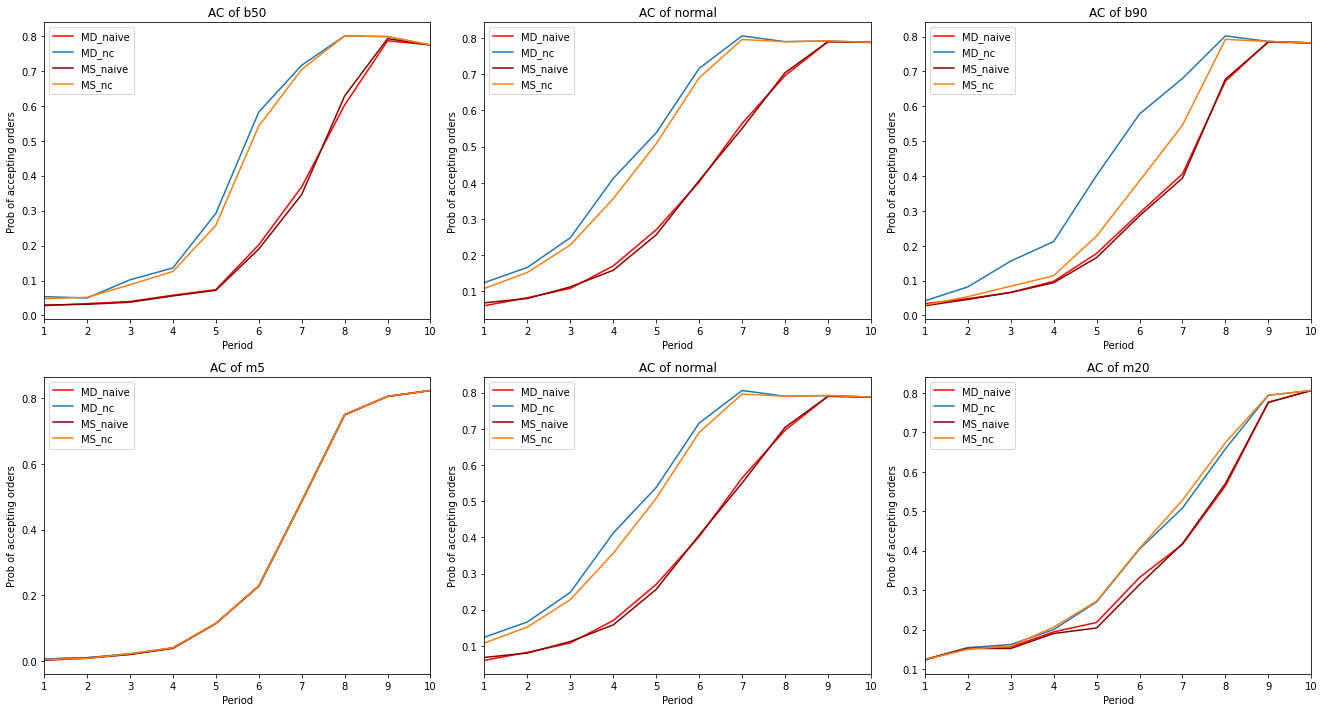

In [328]:
print_item_compare("AC", dfs_concat)

/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs10030746/

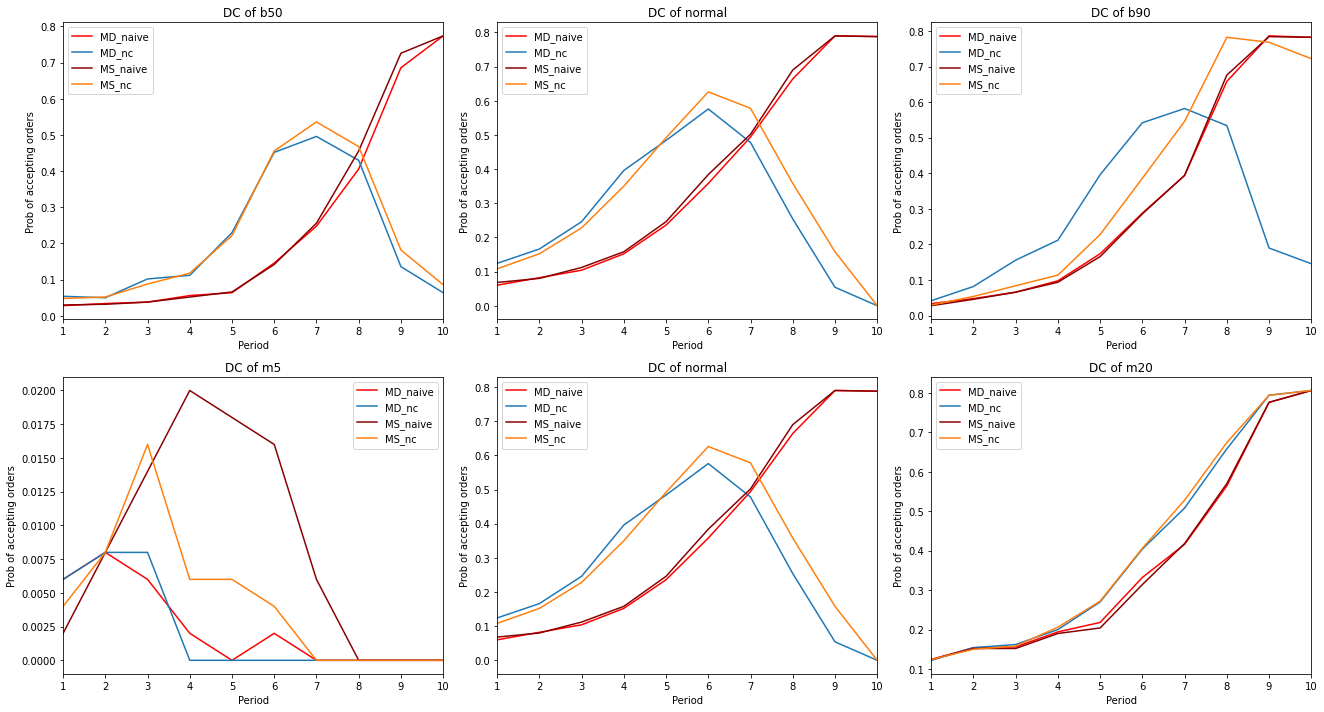

In [329]:
print_item_compare("DC", dfs_concat)

/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs10030746/

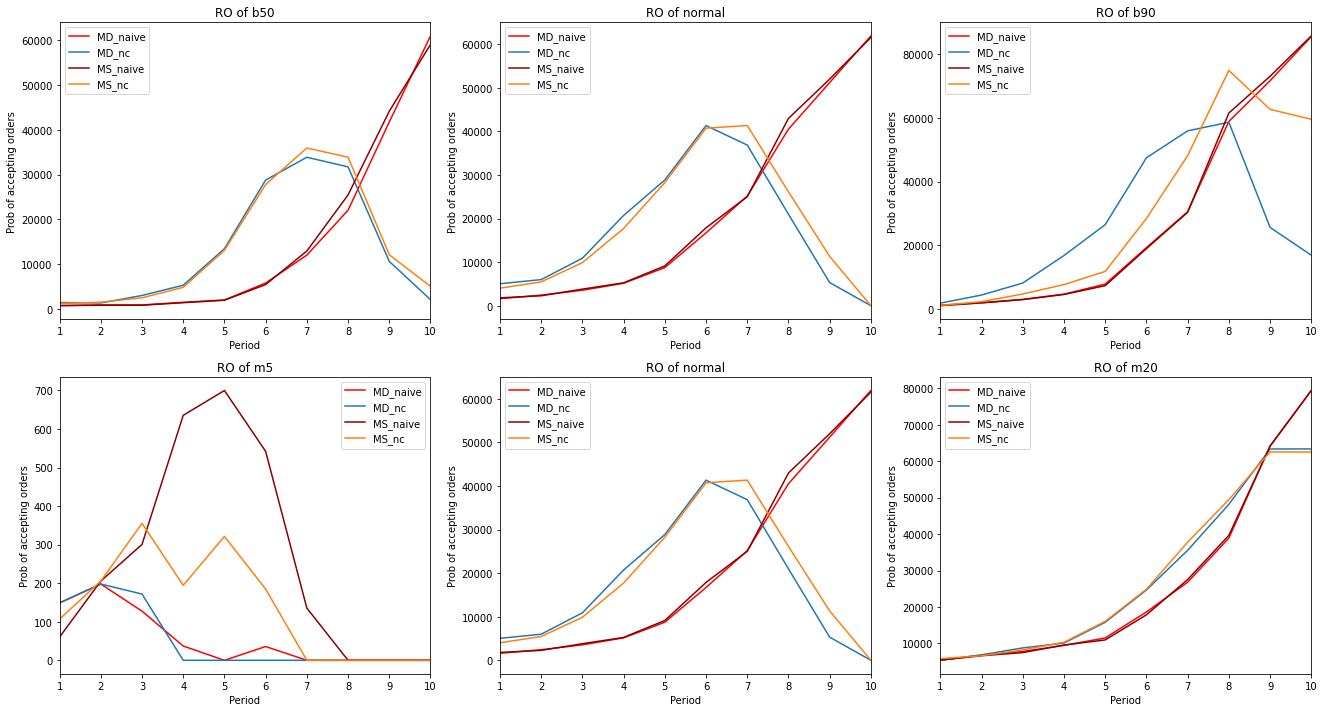

In [330]:
print_item_compare("RO", dfs_concat)

/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs10030746/

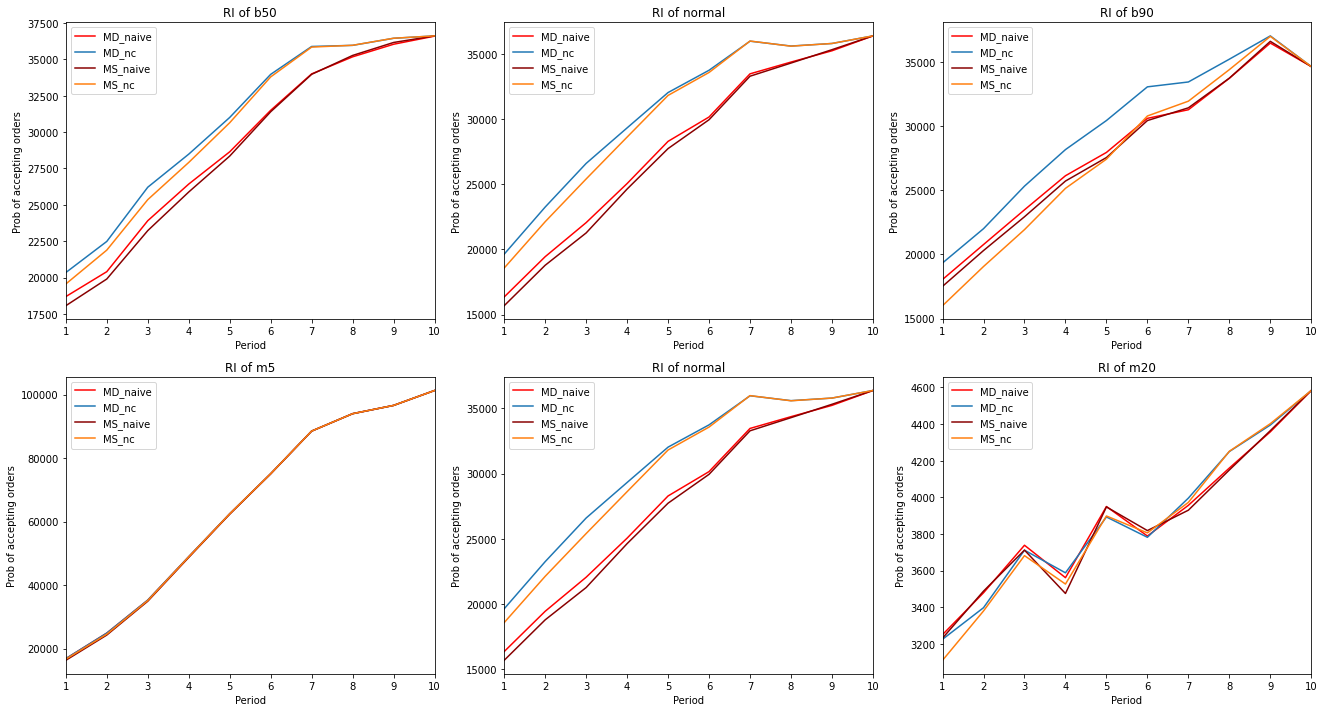

In [331]:
print_item_compare("RI", dfs_concat)

/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs10030746/

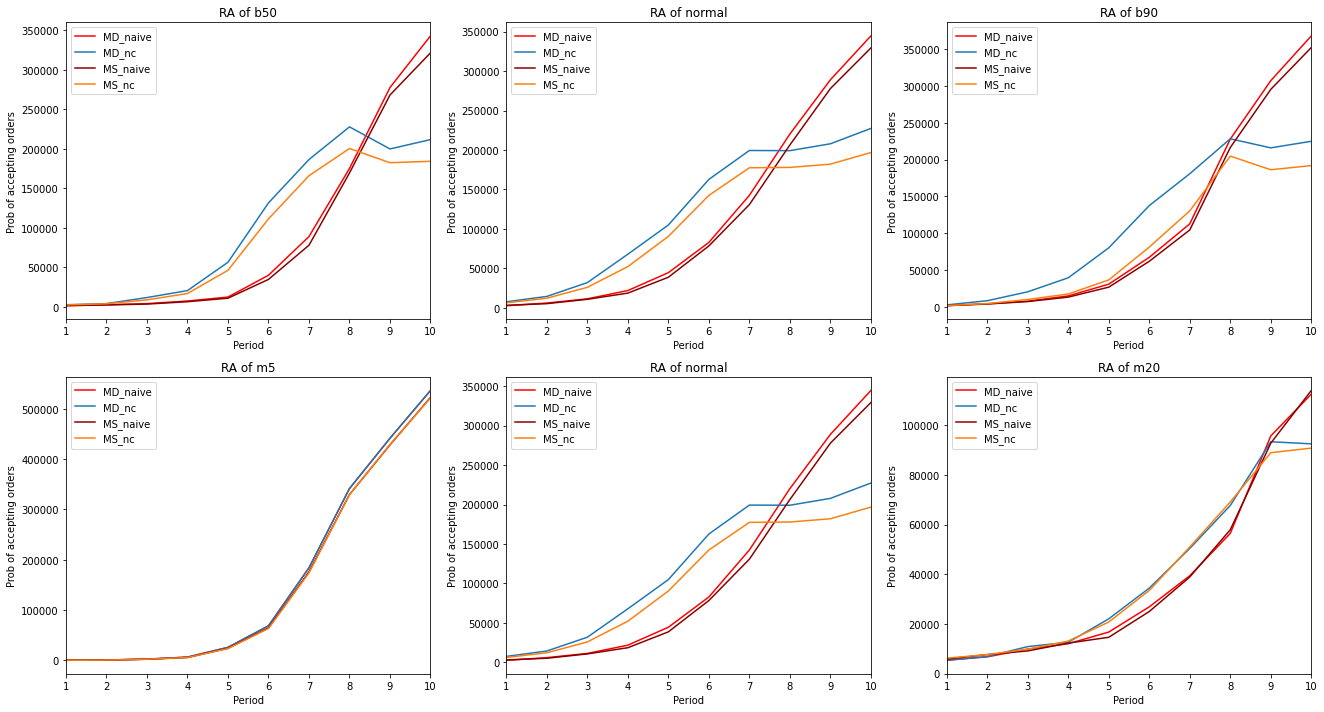

In [332]:
print_item_compare("RA", dfs_concat)

/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/Users/racs10030746/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/Users/racs10030746/

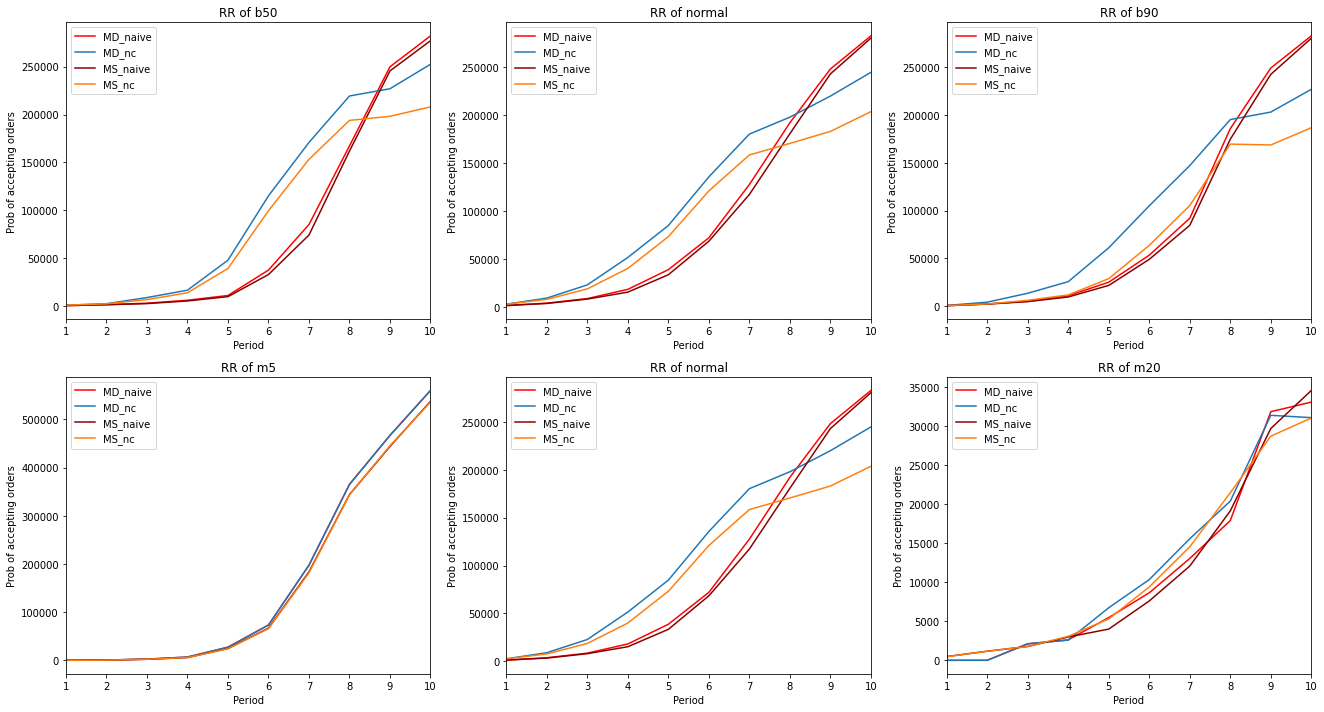

In [333]:
print_item_compare("RR", dfs_concat)

# Debug one file 
___

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
# 讀資料
scenario = "M3_S5I3C25m10b70r2d25K10T10"
folder = "compare/" + scenario + "/"
strategies = ["MD_naive", "MD_smart", "MD_reserved", "MS_naive", "MS_smart", "MS_reserved"]
dfs = {}
for s in strategies:
    path = folder + s + ".csv"
    dfs[s] = pd.read_csv(path)

In [17]:
# Rename
periods = list(range(10, 0, -1))
general = ["Experiment"] + ["order_t" + str(i) for i in periods]
items = {"decision_t":"D", "rev_acc_t":"RA", "rev_rej_t":"RR", "rev_order_t":"RO", "rev_ind_t":"RI"}
revs = {"revenue":"R", "first_k_avg_rev":"AR", "sold_out":"S"}
concat_list = [dfs["MD_naive"][general]]
for s in strategies:
    rename_dic = {r:revs[r]+"_"+s for r in revs}
    rename_dic.update({i+str(t):items[i]+str(t)+"_"+s for i in items for t in periods})
    dfs[s] = dfs[s].rename(columns=rename_dic)
    concat_list.append(dfs[s][list(rename_dic.values())])

# Concat
df = pd.concat(concat_list, axis=1)

In [18]:
df

Experiment  order_t10  order_t9  order_t8  order_t7  order_t6  order_t5  \
0            1          0         1         6         2        10         3   
1            2          0         8         4         3         2         1   
2            3          6         8         4         3         2         1   
3            4          0         3         2         3         8         0   
4            5          0         3         2         2         0        10   
5            6          3        10         0         2         0        10   
6            7          9         5         9         4         5         8   
7            8          0         8         0         0         3         0   
8            9          0         8         0         0         3         0   
9           10          4         3         0         0         7        10   
10          11          4         3         9         1         0         9   
11          12         10        10         9         1         0         9   
12          13          3         5         5         1         6         7   
13          14          3         2         3         2        10         6   
14          15          8         2         3         2        10         6   
15          16          1         9         1         3         4         5   
16          17          1         9        10         3         7         2   
17          18          5         3        10         3         7         2   
18          19          0         0         9         4         1         2   
19          20          0         0         9         4         5         0   
20          21          4         5         6         6         5         0   
21          22          4         5         7         0         4         6   
22          23          2         5         7         0         4         6   
23          24          6         0         5         0         9         3   
24          25          6         0         5         0         9         3   
25          26          0         7         3         0         1         2   
26          27          0         7         3         0         7         0   
27          28          5         2         0         0         7         0   
28          29         10         9        10         1         0         0   
29          30         10         9        10         1         0         0   
30          31          3         5         8         3         4        10   
31          32          3         5         4         2         8         9   
32          33          9         0         4         2         8         9   
33          34          2         7         3         4         2         8   
34          35          2         7         3         4         7         6   
35          36          8         2         1         5         7         6   
36          37          1         9         0         5         0         5   
37          38          0        10         0         9         6         3   
38          39          0        10         0        10         1         5   
39          40          7         6         0         0         1         5   
40          41          0         3         9         0         6         4   
41          42          0         3         9         0         6         1   
42          43          6        10         7         2         0         1   
43          44          6         5         4         1         3         0   
44          45          0         5         4         1         3         0   
45          46          4         0         2         3         9        10   
46          47          4         0         2         3         9         0   
47          48         10         8         0         4         3         0   
48          49         10         1         9         4         6         8   
49          50          3         1         9         

In [19]:
target = "R_"
rev_keys = [target + s for s in strategies]
df[rev_keys].mean()
# dfs["MD_naive"]

R_MD_naive       495217.56
R_MD_smart       460178.32
R_MD_reserved    477189.84
R_MS_naive       496744.40
R_MS_smart       463498.74
R_MS_reserved    454254.54
dtype: float64

In [20]:
def show_avg_result(target, df):
    data = {s:[] for s in strategies}
    for t in periods:
        for s in data:
            key = target + str(t) + "_" + s
            data[s].append(df[key].mean())
    df_item = pd.DataFrame(data, index=periods)
    return df_item

In [21]:
df_item = show_avg_result("RA", df)
df_RA = df_item
df_item

MD_naive       MD_smart  MD_reserved      MS_naive       MS_smart  \
10  304943.56  779172.501761    202356.26  291472.23228  766987.897780   
9   319961.78  886308.701026    245931.34  306900.68412  871230.239333   
8   214581.48  753125.555891    214296.00  199683.93138  740021.756929   
7   121109.22  623366.594258    176485.84  106965.64642  609299.053094   
6    82834.96  636047.489794    158664.54   75703.67320  621878.707510   
5    34298.52  461430.268939     92003.98   37380.92720  463800.386750   
4    20317.12  354151.192093     72077.38   19003.91214  348956.517758   
3    10136.12  234802.687061     45128.66    9125.72292  264851.072883   
2     5108.24   72038.427233     13613.78    4719.41206   73988.295191   
1     3553.58   10565.940000      7288.62    3580.86688   14261.003640   

      MS_reserved  
10  334874.513337  
9   389819.467154  
8   315524.554742  
7   270678.654284  
6   279522.571740  
5   198386.017864  
4   150519.787088  
3   111066.748884  
2    48855.627097  
1    16836.219560

In [22]:
df_item = show_avg_result("RR", df)
df_RR = df_item
df_item

MD_naive       MD_smart  MD_reserved      MS_naive       MS_smart  \
10  251132.00  826764.158207    217835.10  248974.99270  807117.261110   
9   270580.32  941409.463804    258644.36  264320.42246  919711.775788   
8   188133.82  794513.414365    220962.12  174017.26006  777368.278415   
7   106582.96  658615.874364    172935.64   95481.02950  638823.555762   
6    72216.80  643717.810704    145800.88   65764.11648  635038.106462   
5    32117.10  469176.392365     83218.22   34128.82678  466994.117816   
4    15133.02  345208.851477     57896.72   14384.27706  341894.426035   
3     8114.10  223221.575127     33856.72    7170.01346  253551.094039   
2     2855.82   60408.188646      7238.08    2582.12494   64492.418789   
1     1081.46    4453.160000      3211.88    1251.88578    6449.653760   

      MS_reserved  
10  361304.288293  
9   422986.787425  
8   339533.597397  
7   291052.463616  
6   287173.540131  
5   197569.367764  
4   141798.917070  
3    99642.207685  
2    35491.929957  
1     7555.389240

In [23]:
s = "MD_smart"
df_temp = pd.concat([df_RA.add_prefix('RA_')['RA_' + s], df_RR.add_prefix('RR_')['RR_' + s]], axis = 1)
df_temp

RA_MD_smart    RR_MD_smart
10  779172.501761  826764.158207
9   886308.701026  941409.463804
8   753125.555891  794513.414365
7   623366.594258  658615.874364
6   636047.489794  643717.810704
5   461430.268939  469176.392365
4   354151.192093  345208.851477
3   234802.687061  223221.575127
2    72038.427233   60408.188646
1    10565.940000    4453.160000

In [24]:
df_item = show_avg_result("RO", df)
df_item

MD_naive  MD_smart  MD_reserved  MS_naive  MS_smart  MS_reserved
10  53811.56      0.00         0.00  53376.74      0.00         0.00
9   61781.54    436.66         0.00  61900.86    514.30         0.00
8   42729.94    436.66      8156.26  43508.82    514.30         0.00
7   22036.12   3254.98     27677.38  20996.60   3346.48      2449.74
6   16755.18  17893.30     38708.30  17759.44   3914.52      7248.14
5    4147.88  11714.86     19600.26   7125.90  16424.60     15592.46
4    5945.76  30846.98     24526.38   6038.58  31001.68     28601.52
3    2626.58  27944.46     15591.58   2656.44  37557.42     24556.74
2    2390.16  16382.98      7220.98   2480.82  17173.28     18614.88
1    2526.52   6355.46      4181.68   2499.88   8601.02     10101.62

MD_naive       214751.24
MD_smart       115266.34
MD_reserved    145662.82
MS_naive       218344.08
MS_smart       119047.60
MS_reserved    107165.10
dtype: float64


<AxesSubplot:>

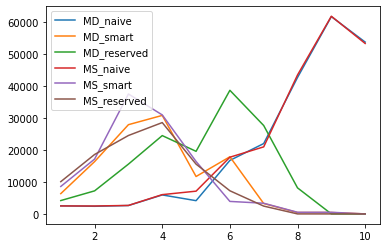

In [25]:
print(df_item.sum())
df_item.plot()

In [27]:
df_item = show_avg_result("RI", df)
df_item.sum()

MD_naive       280466.32
MD_smart       344911.98
MD_reserved    331527.02
MS_naive       278400.32
MS_smart       344451.14
MS_reserved    347089.44
dtype: float64

<AxesSubplot:>

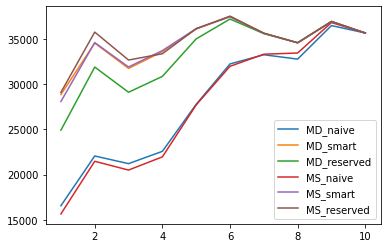

In [28]:
df_item.plot()

In [29]:
df_D = show_avg_result("D",df)
df_D

MD_naive  MD_smart  MD_reserved  MS_naive  MS_smart  MS_reserved
10      0.70      0.00         0.00      0.70      0.00         0.00
9       0.86      0.02         0.00      0.86      0.02         0.00
8       0.66      0.02         0.16      0.72      0.02         0.00
7       0.44      0.14         0.50      0.60      0.12         0.12
6       0.38      0.34         0.68      0.70      0.12         0.16
5       0.14      0.24         0.52      0.52      0.34         0.42
4       0.12      0.48         0.56      0.56      0.48         0.56
3       0.10      0.50         0.50      0.52      0.60         0.70
2       0.06      0.30         0.32      0.34      0.36         0.44
1       0.06      0.18         0.22      0.22      0.28         0.30

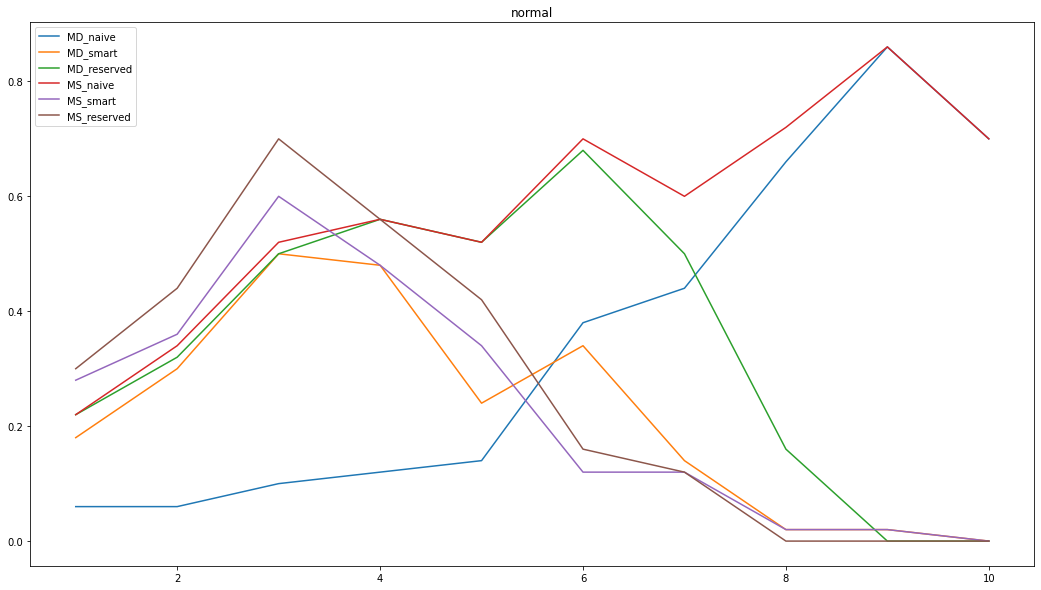

In [30]:
df_D.plot(figsize=(18,10), title="normal")
plt.savefig("compare/" + scenario + "/decision.jpg")


# 統合分析